In [3]:
## load packages 
import pandas as pd
import re
import numpy as np

## nltk imports
#!pip install nltk # can install on terminal or by uncommenting this line
#import nltk; nltk.download('punkt'); nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt

## sklearn imports
from sklearn.feature_extraction.text import CountVectorizer

## lda
#!pip install gensim # can install by uncommenting this line
from gensim import corpora
import gensim

## sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## visualizing LDA--likely need to install
#!pip install pyLDAvis # can install by uncommenting this line
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## random
import random
import string; punctlist = [char for char in string.punctuation] # list of english punctuation marks

import spacy
sp = spacy.load('en_core_web_sm')
import en_core_web_sm
nlp = en_core_web_sm.load()
import ast
import networkx as nx
import urllib, json
from itertools import combinations
from collections import Counter
from netwulf import visualize
import seaborn as sns
import os

## Define Functions
here are a few helper functions to keep things organized.
These handle things like filtering data by brand and comparing sentiment between branded and non-branded hashtags.

In [1]:
# To compare the average sentiment of branded vs. non-branded Instagram posts for each hashtag used by a specific brand, and return the hashtags where the difference is most noticeable.
def compare_branded_hashtags(df, brand_name):
    filtered = df[df["brand"] == brand_name]
    sentiment = (
        filtered.groupby(["hashtags", "is_branded_content"])
        .agg(avg_sentiment=("compound", "mean"), count=("hashtags", "count"))
        .reset_index()
    )
    pivot = sentiment.pivot_table(
        index="hashtags",
        columns="is_branded_content",
        values="avg_sentiment"
    )
    pivot = pivot.rename(columns={
        True: "branded_sentiment", 
        False: "non_branded_sentiment"
    })
    pivot["diff"] = pivot.get("branded_sentiment", 0) - pivot.get("non_branded_sentiment", 0)

    return pivot.dropna().sort_values("diff", ascending=False)


In [2]:
def compute_sentiment(text_series):
    sent_obj = SentimentIntensityAnalyzer()
    return text_series.astype(str).apply(sent_obj.polarity_scores).apply(lambda x: x["compound"])


## Load Data
 Set paths and load the cleaned Instagram dataset

In [4]:
data_path = '../../../data/'
output_path = '../../../output/sentiment_analysis/'

In [5]:
all_df = pd.read_csv(f"{data_path}/all_instagram_cleaned.csv")
all_df.head()

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_1005/974923463.py:1: DtypeWarning: Columns (3,4,17) have mixed types. Specify dtype option on import or set low_memory=False.
  all_df = pd.read_csv(f"{data_path}/all_instagram_cleaned.csv")


,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.name,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,brand,text_clean,text_clean_str
0,albums,2025-05-29T13:40:32+00:00,NaN,9037049469730638.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T14:09:23+00:00,"[{""id"":""1195280392333492"",""type"":""photo"",""url""...",...,NykaaLuxe,nykaaluxe,0.0,5.0,NaN,NaN,Every makeup look starts with the right founda...,Estée Lauder,"['everi', 'start', 'right', 'foundat', 'readi'...",everi start right foundat readi find swipe dis...
1,videos,2025-05-29T11:00:00+00:00,"[""esteelauder"",""esteelauderph""]",677638275152084.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:42:48+00:00,"[{""id"":""677638275152084"",""type"":""video"",""durat...",...,Estée Lauder Philippines Market,esteelauderph,0.0,9.0,258.0,2025-05-29,"Rose-tinted beauty, made to flatter every look...",Estée Lauder,"['rosetint', 'made', 'flatter', 'everi', 'whet...",rosetint made flatter everi whether your go su...
2,videos,2025-05-29T10:11:30+00:00,NaN,664046526456955.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T11:16:00+00:00,"[{""id"":""664046526456955"",""type"":""video"",""durat...",...,ION Orchard,ion_orchard,0.0,6.0,558.0,2025-05-29,A Day Like No Other is coming on 6 June! Enjoy...,Estée Lauder,"['day', 'june', 'enjoy', 'special', 'partner',...",day june enjoy special partner rebat boost par...
3,albums,2025-05-28T13:00:25+00:00,"[""palmbeach"",""modernluxuryinteriors"",""modernlu...",2187097268387284.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-28T13:11:41+00:00,"[{""id"":""1215820702879124"",""type"":""photo"",""url""...",...,Modern Luxury,modernluxury,66.0,3217.0,58152.0,2025-05-29,Aerin Lauder cultivates an elegant legacy in f...,Estée Lauder,"['aerin', 'cultiv', 'eleg', 'legaci', 'full', ...",aerin cultiv eleg legaci full bloom freshli re...
4,videos,2025-05-28T11:00:00+00:00,"[""est\u00e9eessentials"",""esteelauder"",""esteela...",1230348168650378.0,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/co...,2025-05-29T00:10:07+00:00,"[{""id"":""1230348168650378"",""type"":""video"",""dura...",...,Estée Lauder Philippines Market,esteelauderph,1.0,17.0,828.0,2025-05-29,Beauty that moves with ease — through coffee r...,Estée Lauder,"['move', 'eas', 'coffe', 'run', 'quiet', 'mome...",move eas coffe run quiet moment everyth effort...


## Sentiment Analysis

In [8]:
all_df["compound"] = compute_sentiment(all_df["text_clean_str"])

<Figure size 1200x600 with 0 Axes>

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_1005/712586809.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=all_df, x="brand", y="compound", palette="Set2")


<Axes: xlabel='brand', ylabel='compound'>

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Estée Lauder'),
  Text(1, 0, 'Tarte'),
  Text(2, 0, 'Innisfree'),
  Text(3, 0, 'e.l.f'),
  Text(4, 0, 'Glossier'),
  Text(5, 0, 'Laneige'),
  Text(6, 0, 'Sulwhasoo'),
  Text(7, 0, 'Etude'),
  Text(8, 0, 'COSRX'),
  Text(9, 0, 'Fenty Beauty')])

Text(0.5, 1.0, 'Sentiment Distribution per Brand')

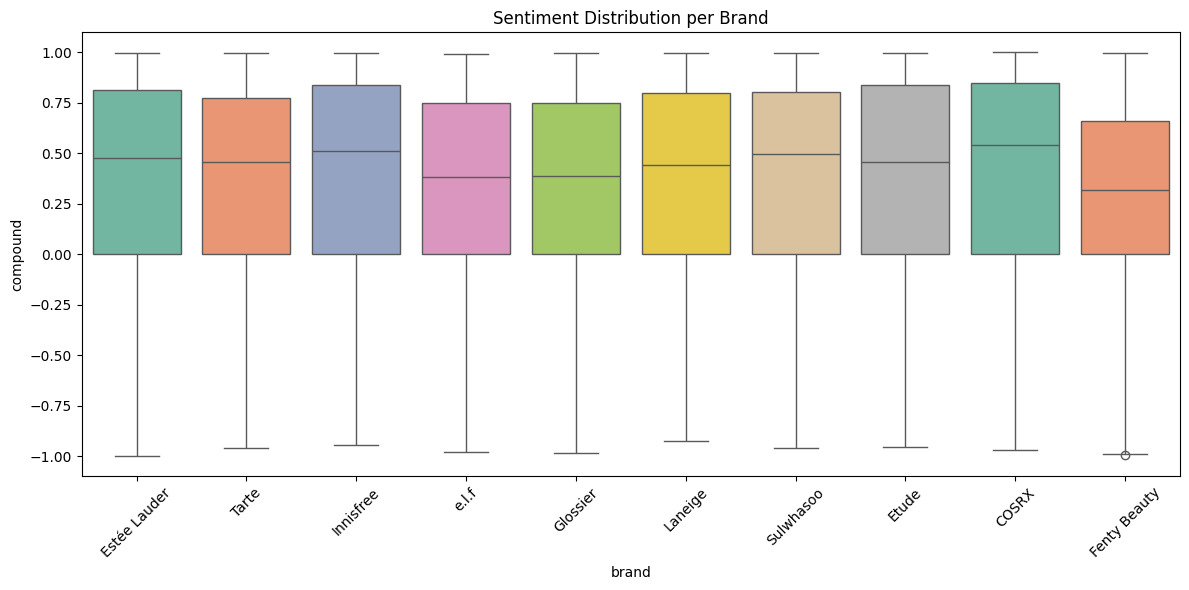

<Figure size 640x480 with 0 Axes>

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=all_df, x="brand", y="compound", palette="Set2")
plt.xticks(rotation=45)
plt.title("Sentiment Distribution per Brand")
plt.tight_layout()
plt.show()
plt.savefig("sentiment_distribution_per_brand.png", dpi=300, bbox_inches='tight')
plt.savefig(output_path + "sentiment_distribution_per_brand.png", dpi=300, bbox_inches='tight')

<Axes: ylabel='brand'>

Text(0.5, 1.0, 'Average Sentiment Score by Brand')

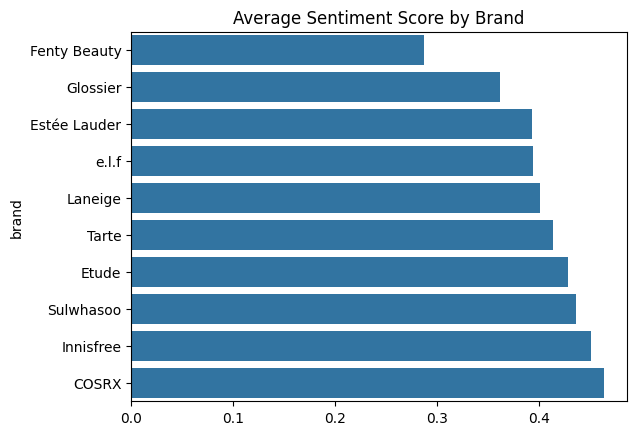

In [10]:
avg_sentiment = all_df.groupby("brand")["compound"].mean().sort_values()
sns.barplot(x=avg_sentiment.values, y=avg_sentiment.index)
plt.title("Average Sentiment Score by Brand")
plt.savefig(output_path + "average_sentiment_by_brand.png", dpi=300, bbox_inches='tight')

In [47]:
## Define brand origin
korean_brands = ["Innisfree", "Laneige", "Sulwhasoo", "Etude", "COSRX"]
all_df["origin"] = all_df["brand"].apply(lambda b: "Korean" if b in korean_brands else "Western")

In [48]:
## define engagemnt metric
all_df["engagement_rate"] = all_df["statistics.like_count"] / (all_df["statistics.views"] + 1)
all_df["log_engagement"] = np.log1p(all_df["engagement_rate"])

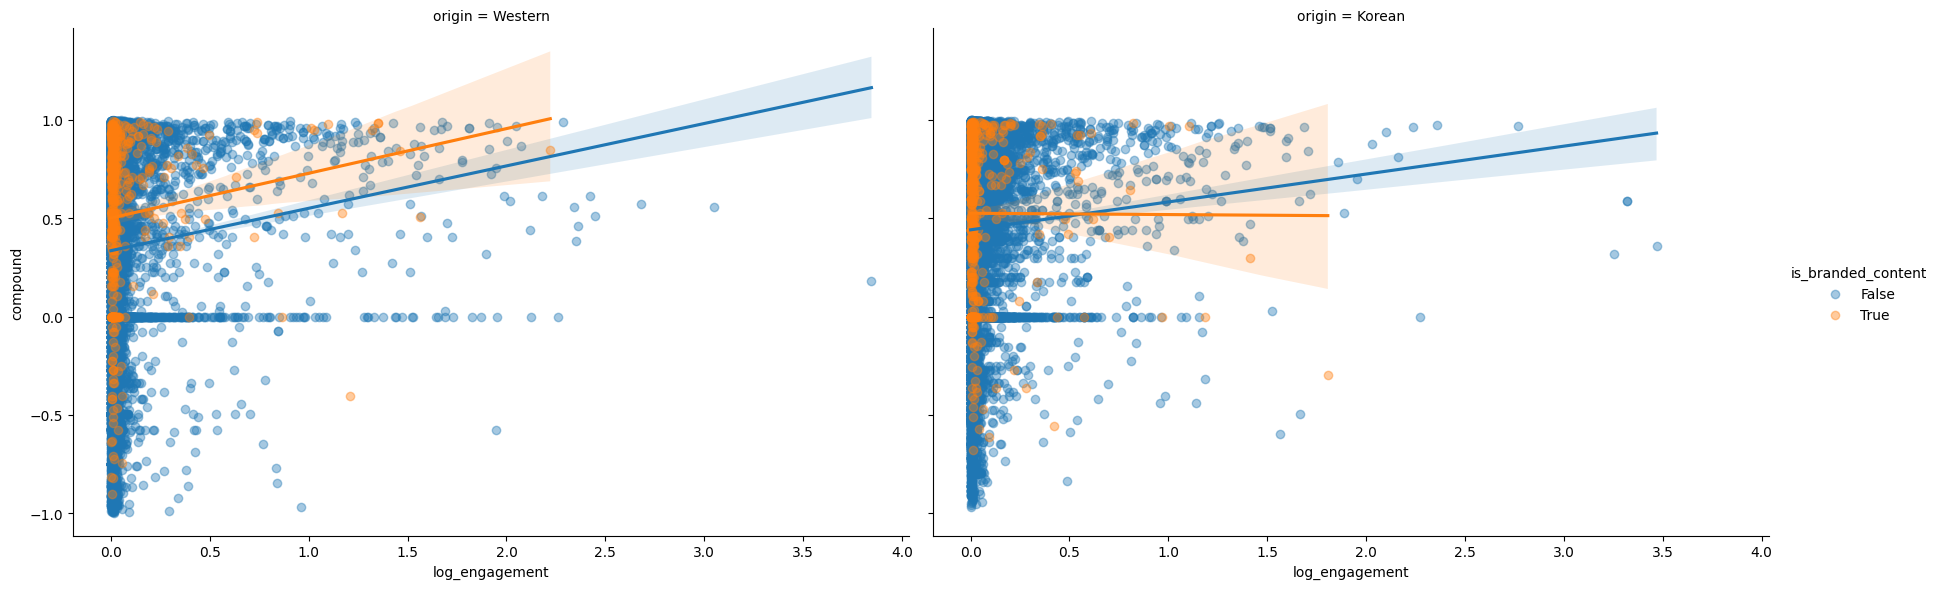

In [49]:
sns.lmplot(
    data=all_df,
    x="log_engagement",
    y="compound",
    hue="is_branded_content",
    col="origin",
    scatter_kws={"alpha": 0.4},
    height=6,
    aspect=1.5
)
plt.savefig(output_path + "sentiment_vs_engagement_vs_country.png", dpi=300, bbox_inches='tight')

## Hashtags & Sentiment

In [51]:
## convert to list 
all_df['hashtags'] = all_df['hashtags'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else x
)
hashtag_df = all_df.explode("hashtags")

In [52]:
#normalize hashtag text
hashtag_df["hashtags"] = hashtag_df["hashtags"].astype(str).str.lower().str.strip()
hashtag_df = hashtag_df[hashtag_df["hashtags"].notna() & (hashtag_df["hashtags"] != "")]

In [53]:
# Aggregate sentiment per brand and hashtag
hashtag_sentiment = (
    hashtag_df.groupby(["brand", "hashtags"])
    .agg(avg_sentiment=("compound", "mean"), count=("hashtags", "count"))
    .reset_index()
)

In [54]:
hashtag_stats = (
    hashtag_df.groupby("hashtags")
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .sort_values(by="avg_sentiment", ascending=False)
)

In [55]:
filtered = hashtag_stats[hashtag_stats["count"] >= 50]
filtered.head()

,avg_sentiment,count
hashtags,,
giveawaytime,0.935403,115
giveaways,0.926472,136
giveawaycontest,0.923157,127
skintreatsmaldives,0.919447,66
beatbybarbii,0.916275,162


In [57]:
# Ensure output directory exists
# Group by origin, branded status, and hashtag
grouped = (
    hashtag_df.groupby(["origin", "is_branded_content", "hashtags"])
    .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
    .reset_index()
)

# Only keep hashtags with sufficient data
grouped = grouped[grouped["count"] >= 5]

# Pivot to compare branded vs. non-branded sentiment per hashtag
origin_comparisons = {}

for origin in ["Korean", "Western"]:
    origin_df = grouped[grouped["origin"] == origin]
    pivot = origin_df.pivot_table(
        index="hashtags",
        columns="is_branded_content",
        values="avg_sentiment"
    )
    pivot = pivot.rename(columns={True: "branded_sentiment", False: "non_branded_sentiment"})
    pivot["diff"] = pivot.get("branded_sentiment", 0) - pivot.get("non_branded_sentiment", 0)
    pivot = pivot.dropna().sort_values("diff", ascending=False)

    print(f"\n{origin} Brands: Top differences in branded vs. non-branded sentiment")
    display(pivot.head(10))

    # Save in case you change your mind
    # safe_name = region.lower()
    # pivot.to_csv(os.path.join(output_dir, f"{safe_name}_branded_vs_nonbranded.csv"), encoding="utf-8")




Korean Brands: Top differences in branded vs. non-branded sentiment


is_branded_content,non_branded_sentiment,branded_sentiment,diff
hashtags,,,
shooting,-0.246833,0.846583,1.093417
international,-0.052848,0.614640,0.667488
campaign,0.382132,0.925620,0.543488
innisfreeatsephora,0.380918,0.854720,0.473802
clio,0.369775,0.828920,0.459145
sephoracanada,0.425732,0.870050,0.444318
koreancosmetics,0.494762,0.927687,0.432925
natural,0.429607,0.861967,0.432360
aesthetic,0.112819,0.542857,0.430038



Western Brands: Top differences in branded vs. non-branded sentiment


is_branded_content,non_branded_sentiment,branded_sentiment,diff
hashtags,,,
reels,0.282525,0.867477,0.584952
sephorainjcp,0.252944,0.816240,0.563296
makeupartistsworldwide,0.391562,0.951400,0.559838
gloss,0.191690,0.747540,0.555850
millennialpink,0.402158,0.905367,0.503209
reelitfeelit,0.169884,0.669783,0.499900
ubcollective,0.097413,0.589357,0.491945
glowrecipe,0.485883,0.958340,0.472457
reelsinstagram,0.297711,0.764920,0.467209


<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'COSRX: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

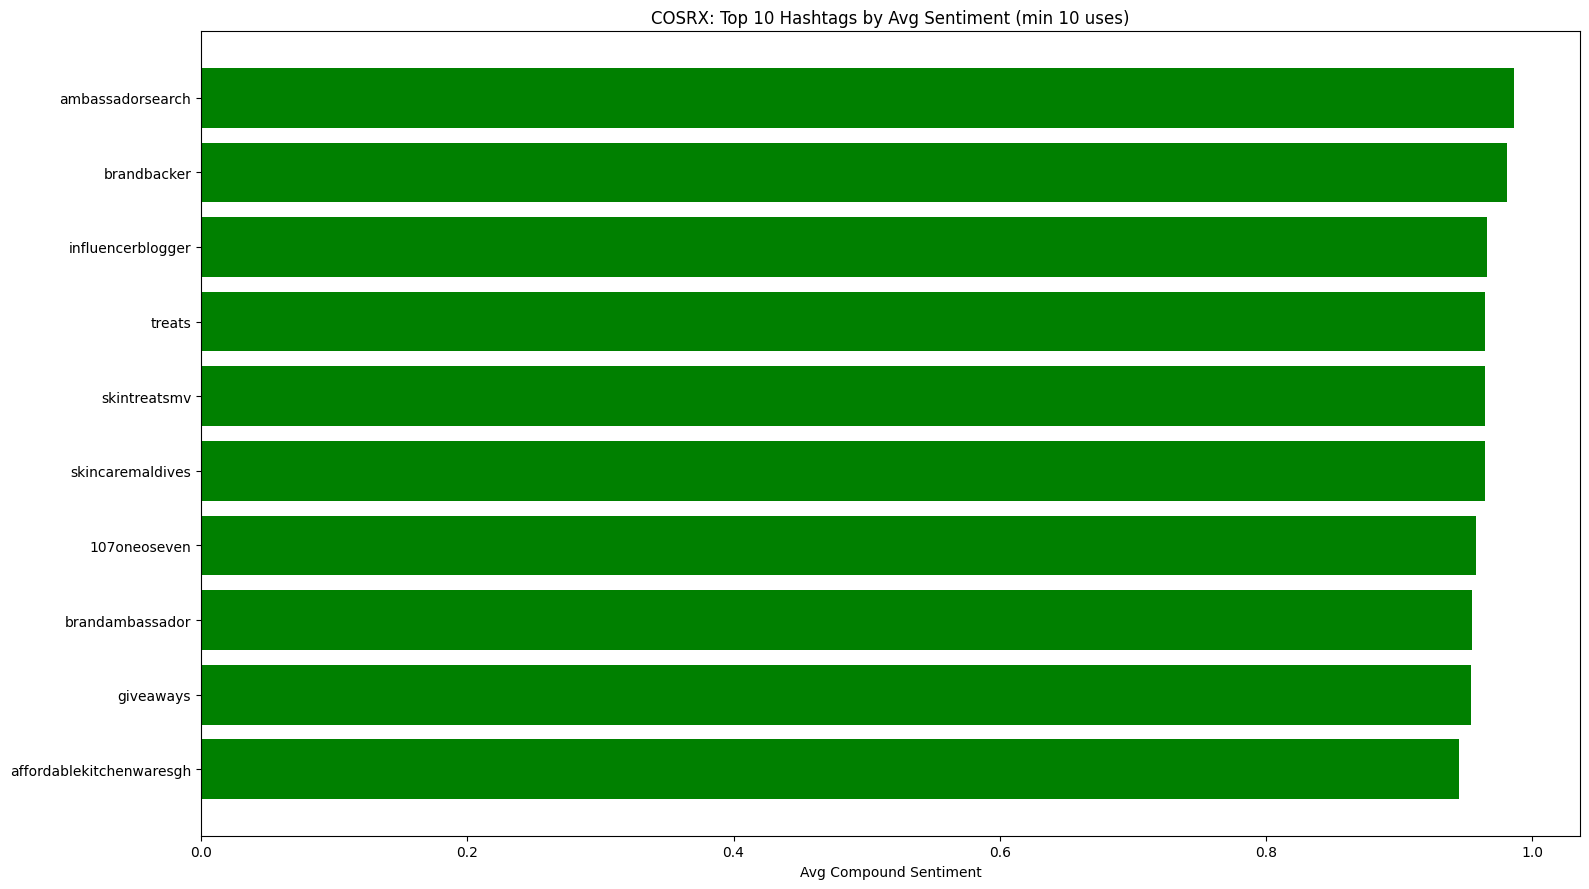

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'COSRX: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Estée Lauder: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

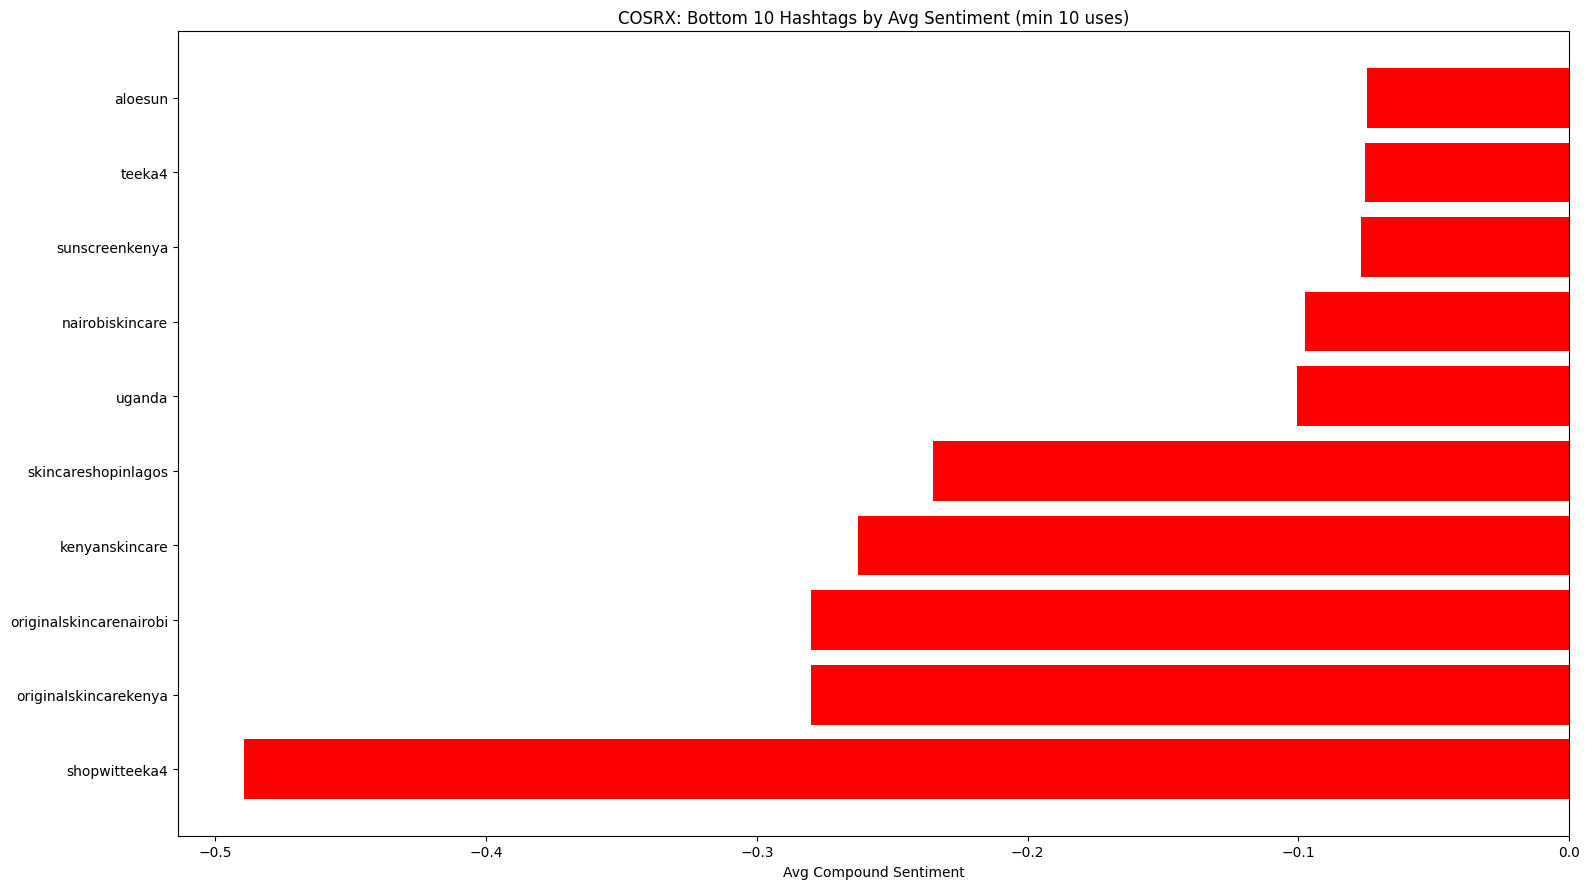

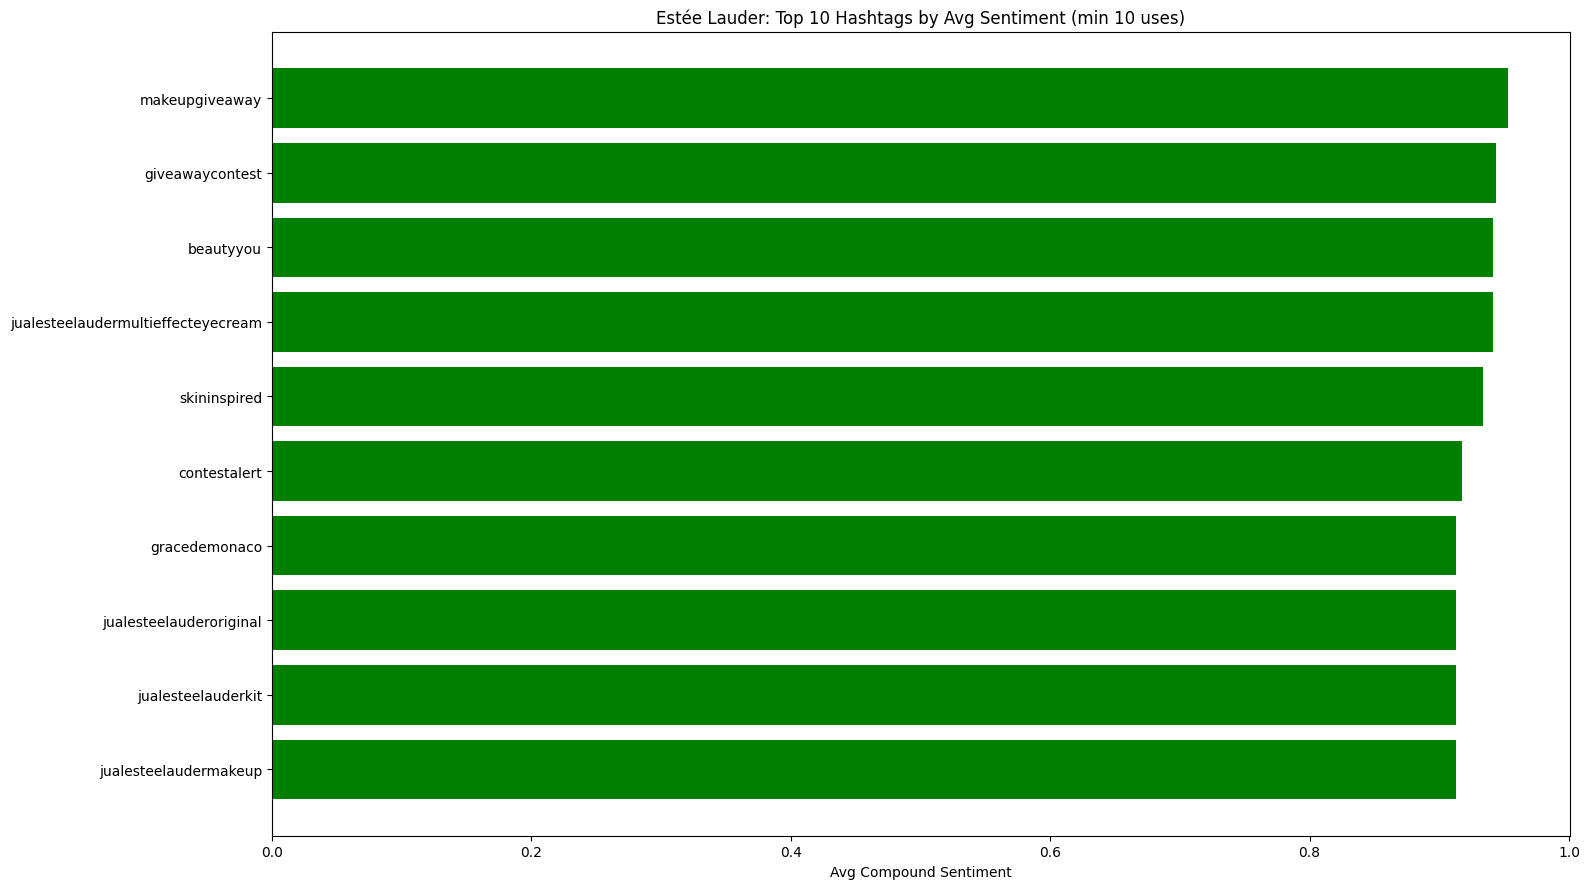

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Estée Lauder: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Etude: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

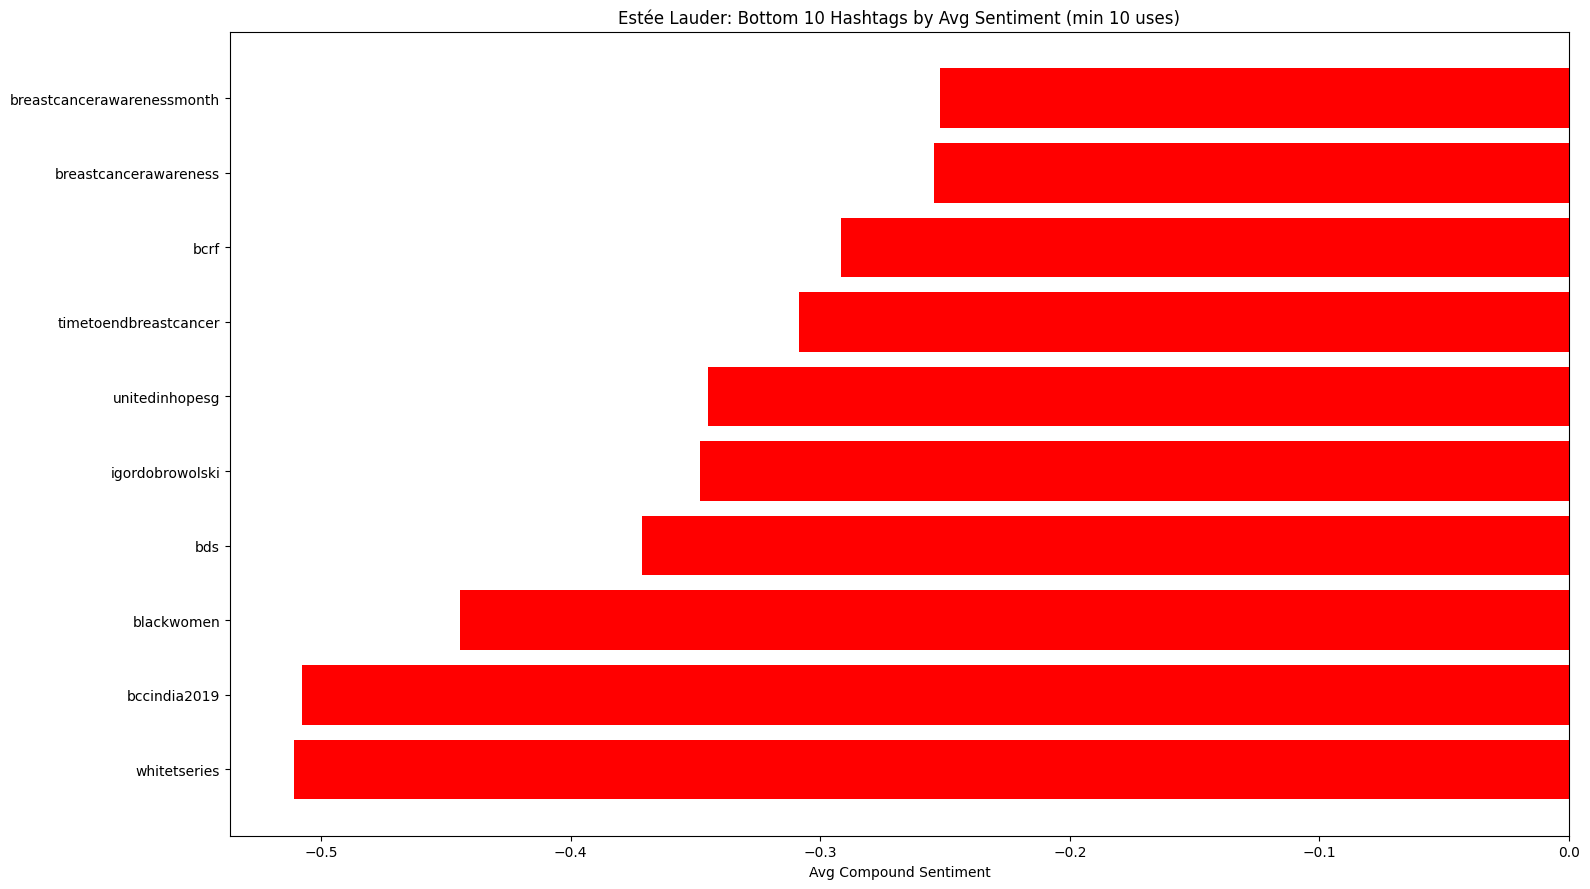

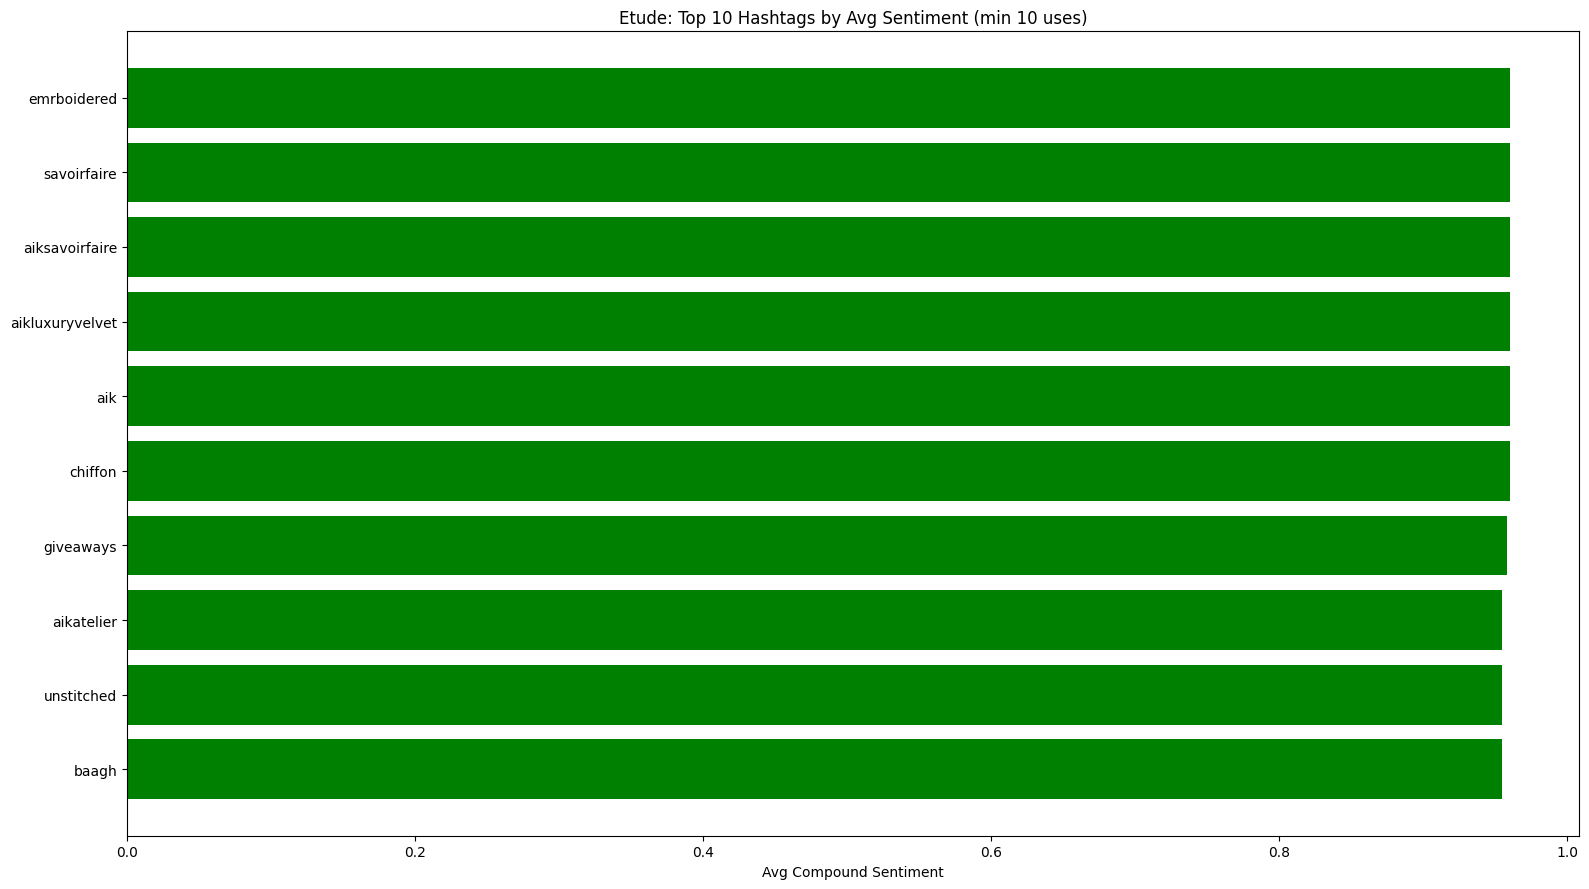

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Etude: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Fenty Beauty: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

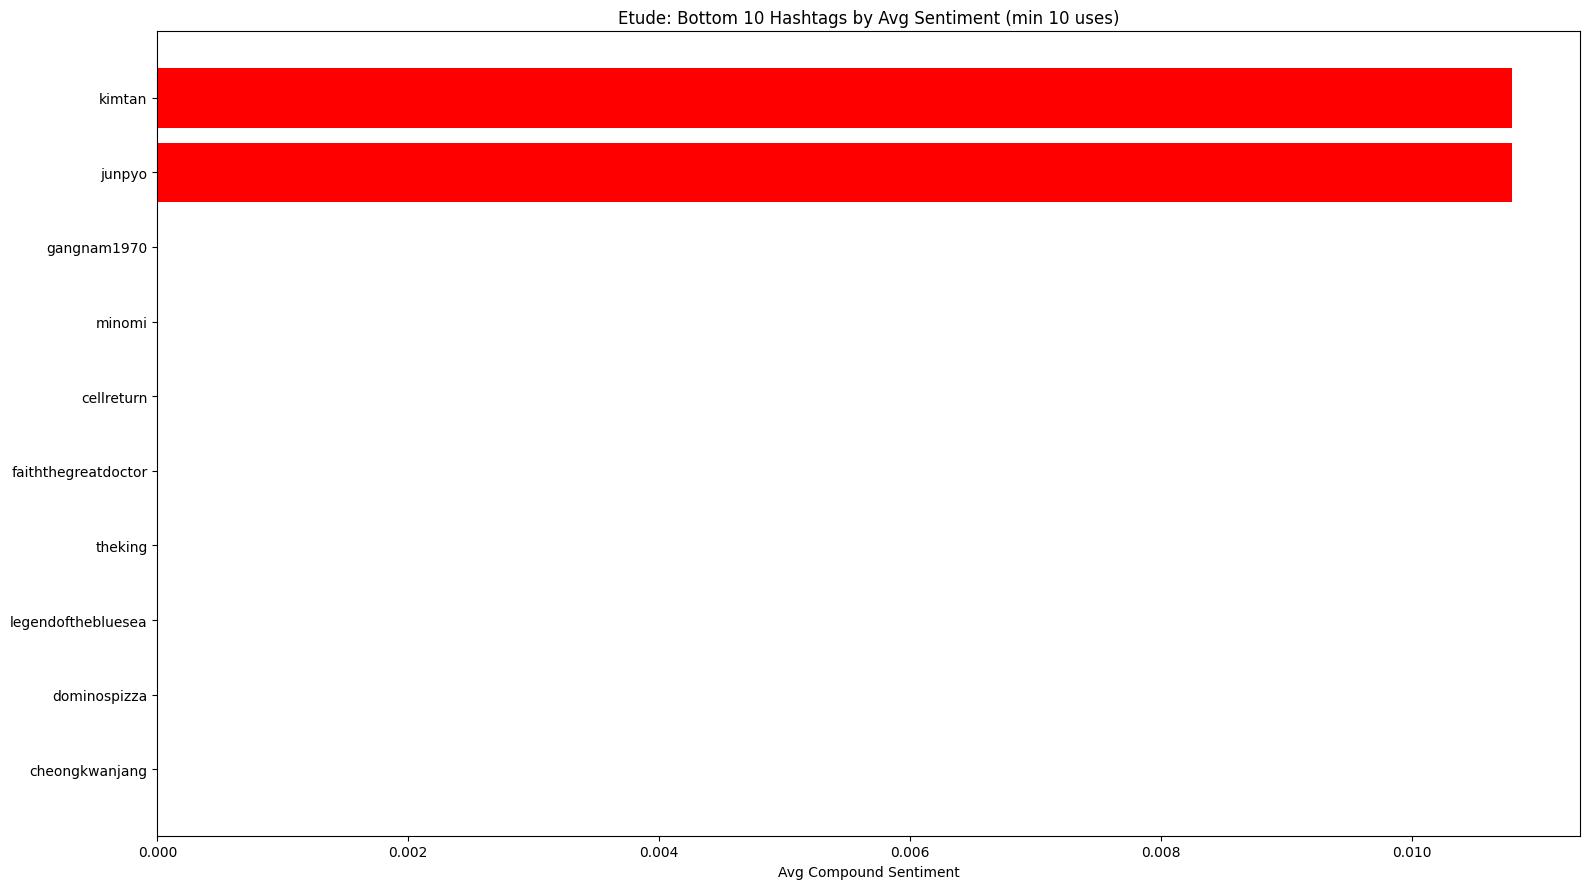

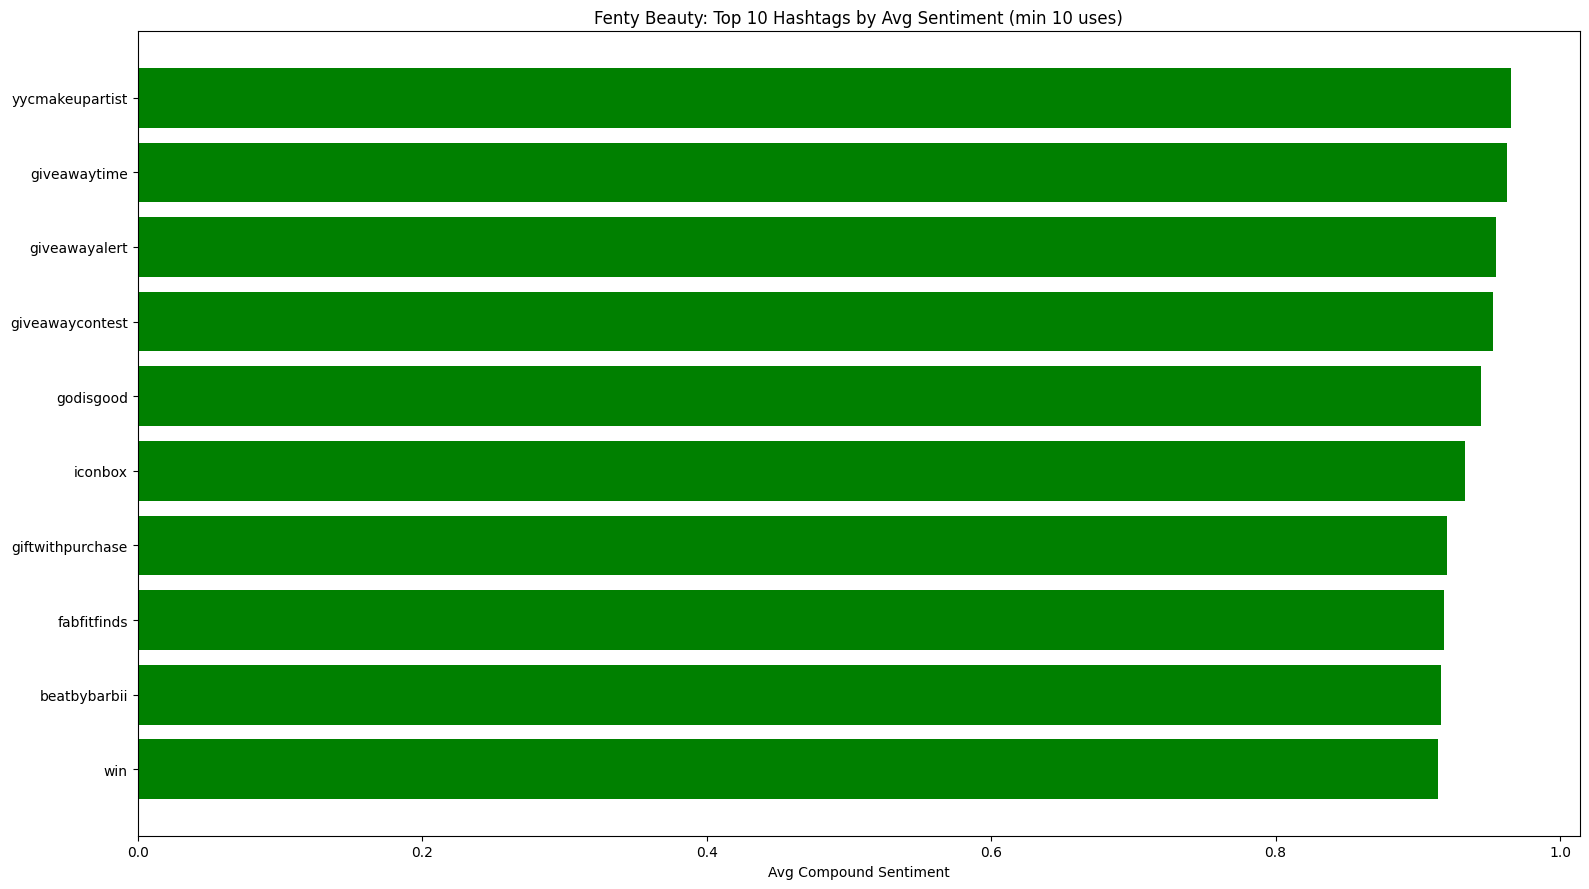

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Fenty Beauty: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Glossier: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

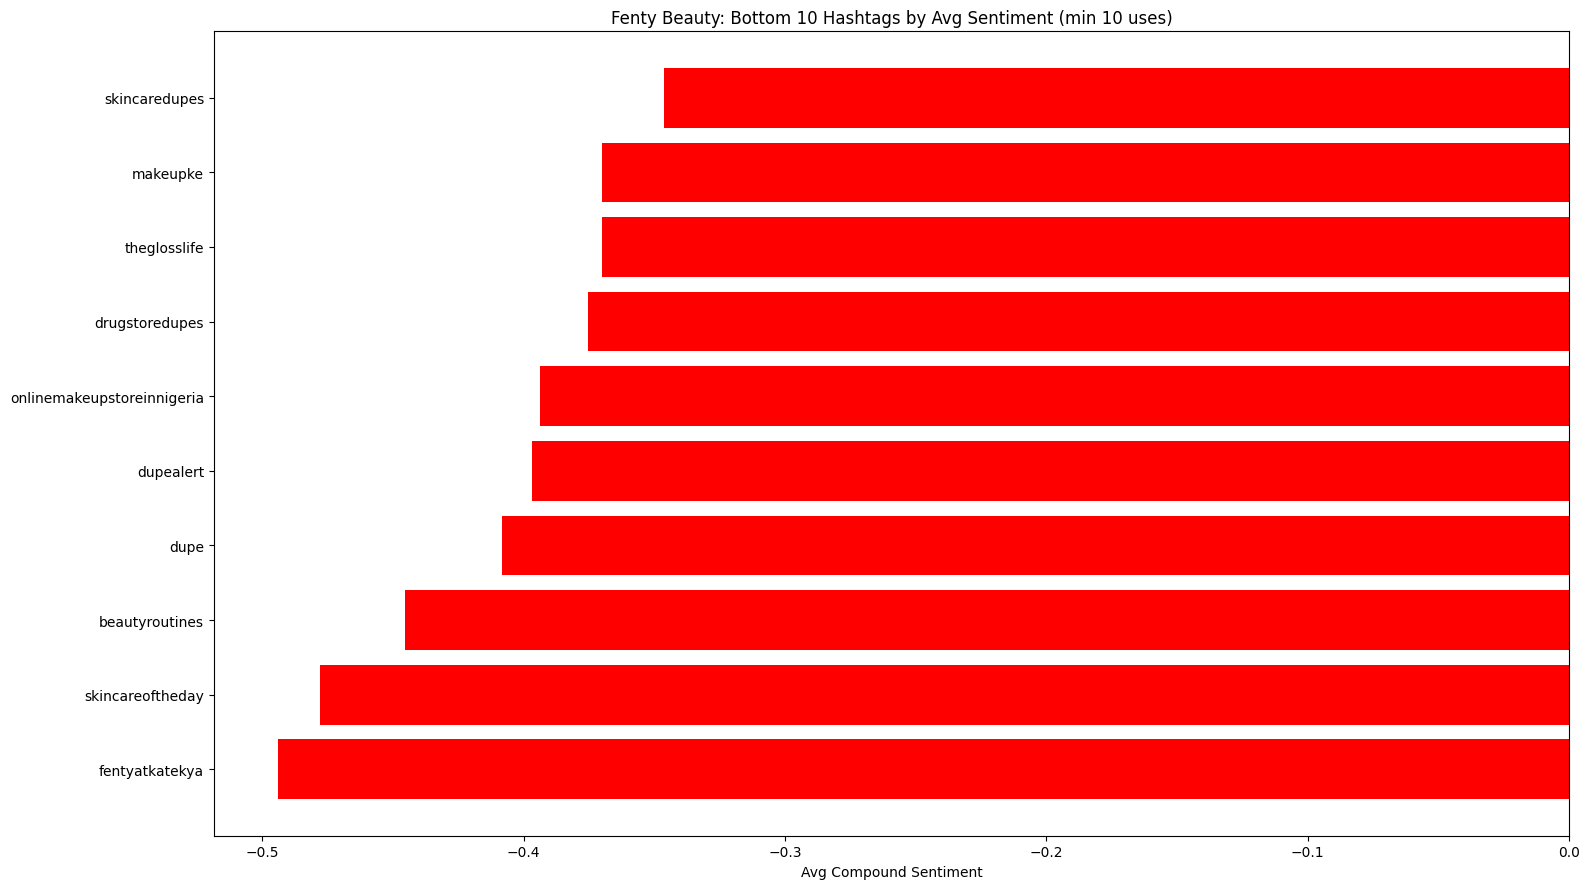

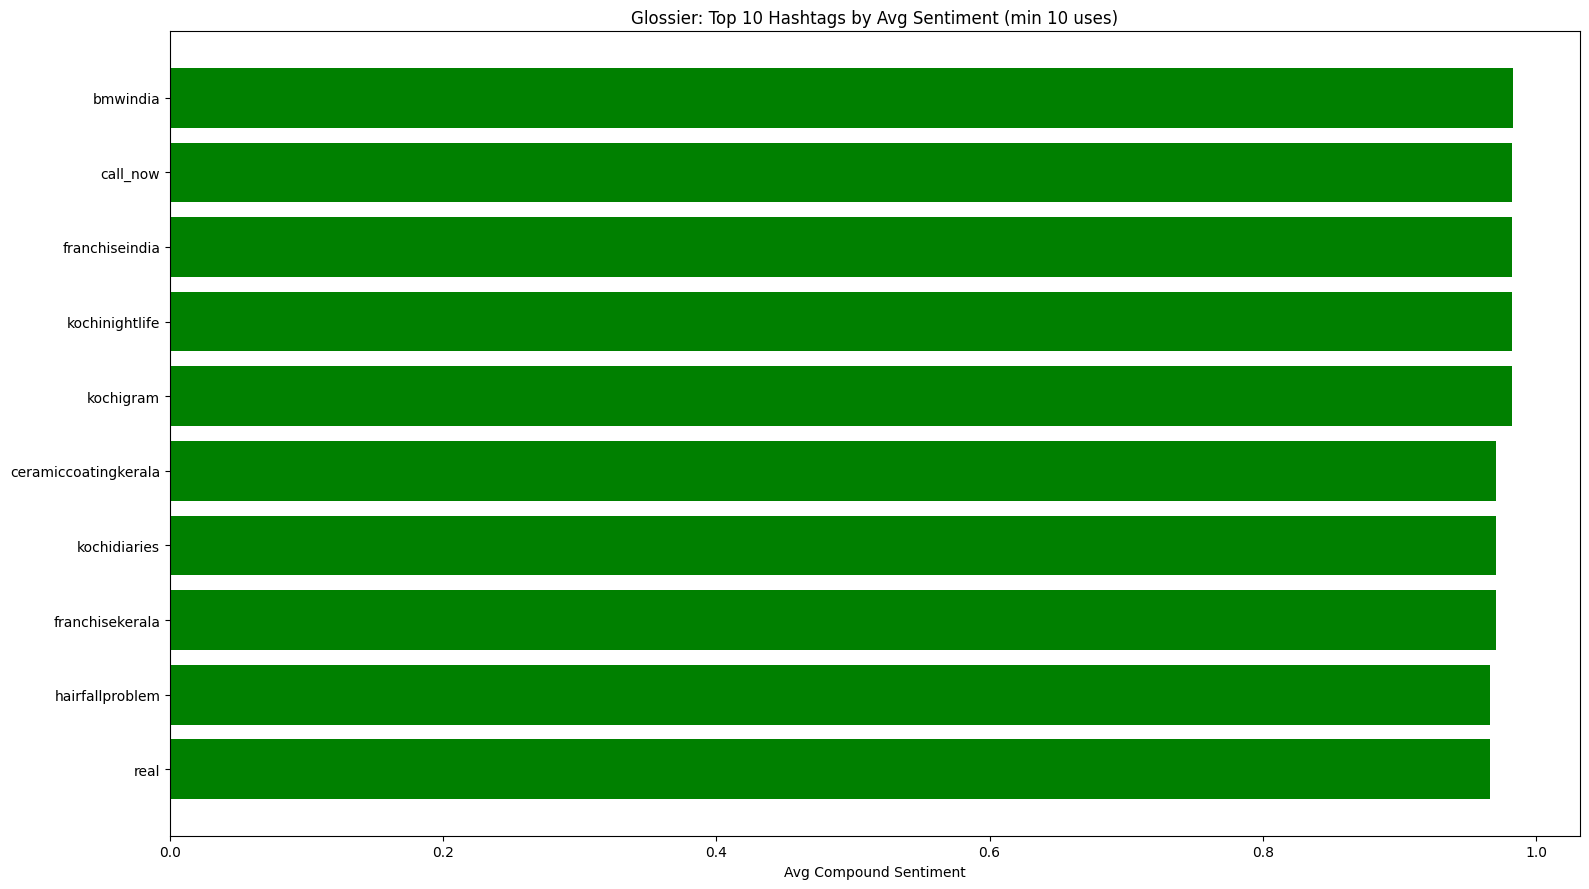

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Glossier: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Innisfree: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

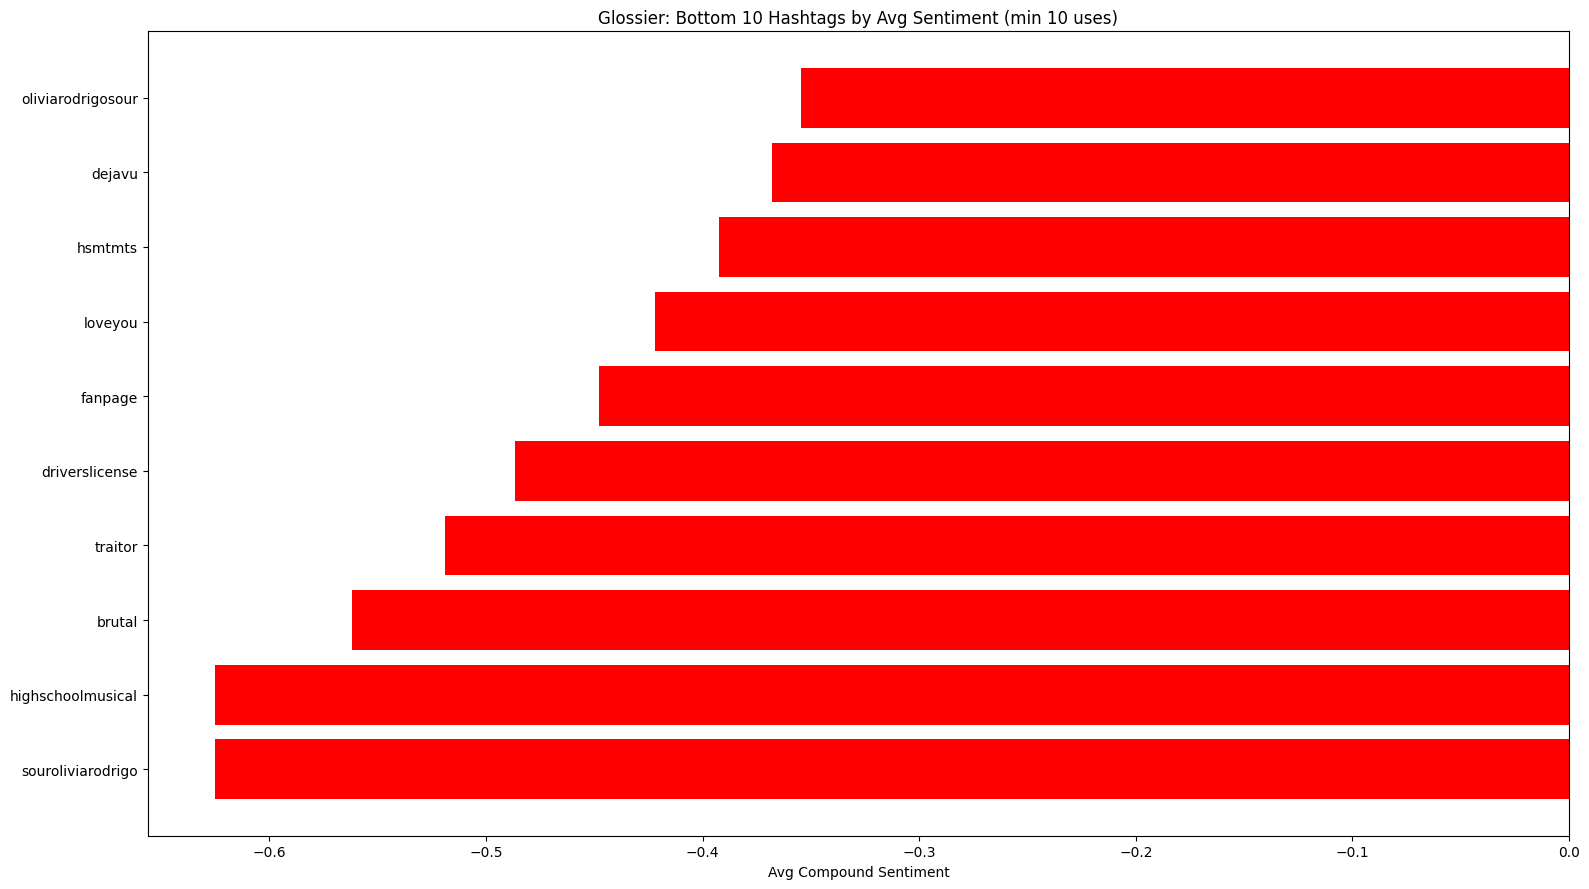

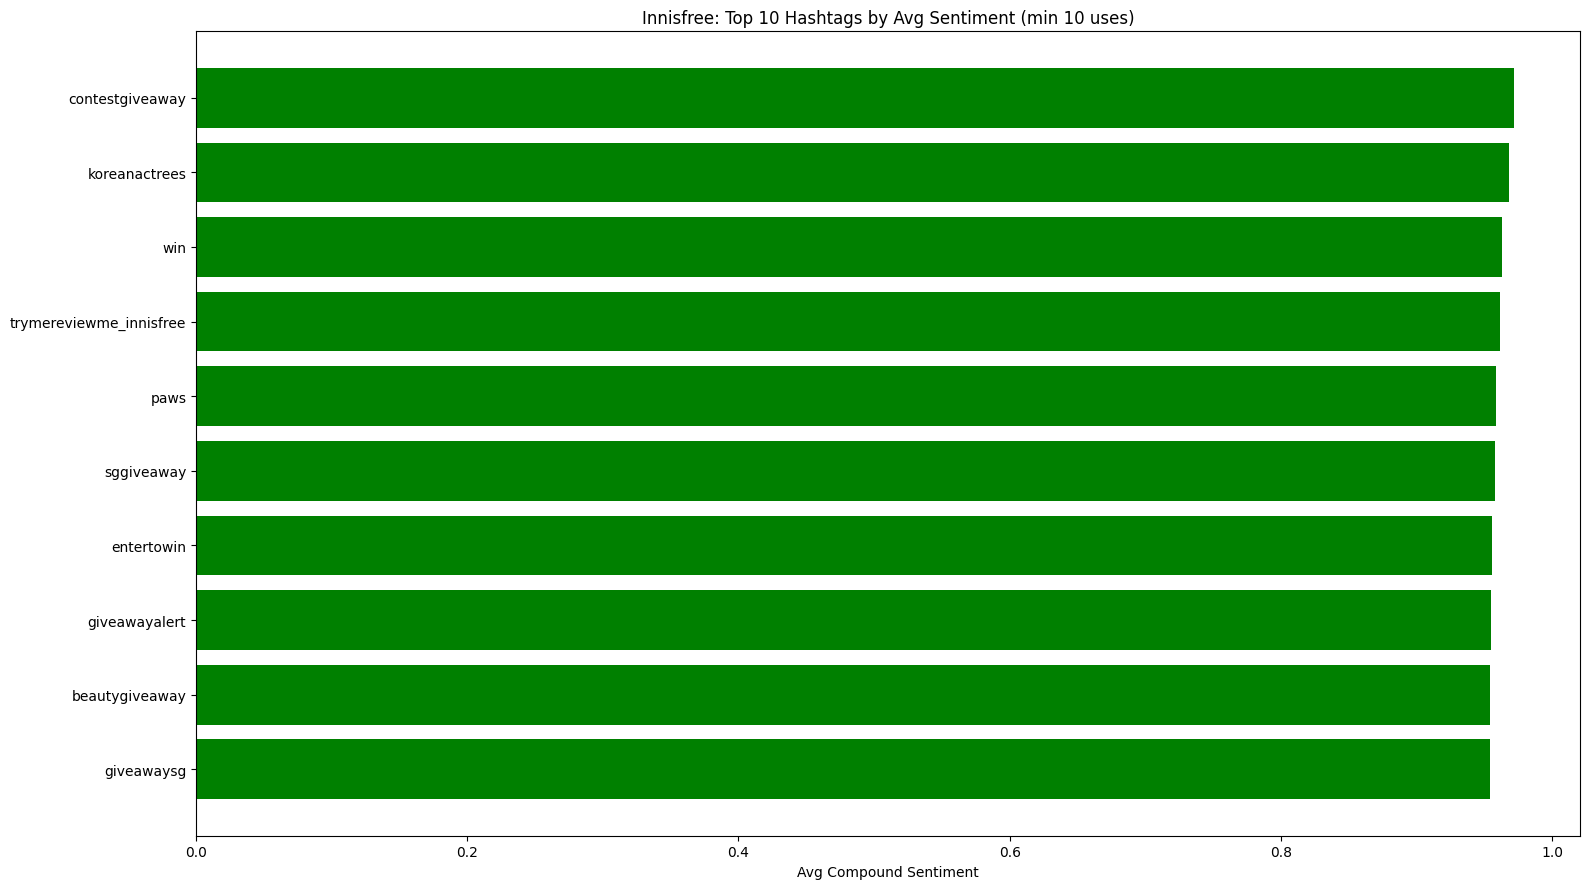

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Innisfree: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Laneige: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

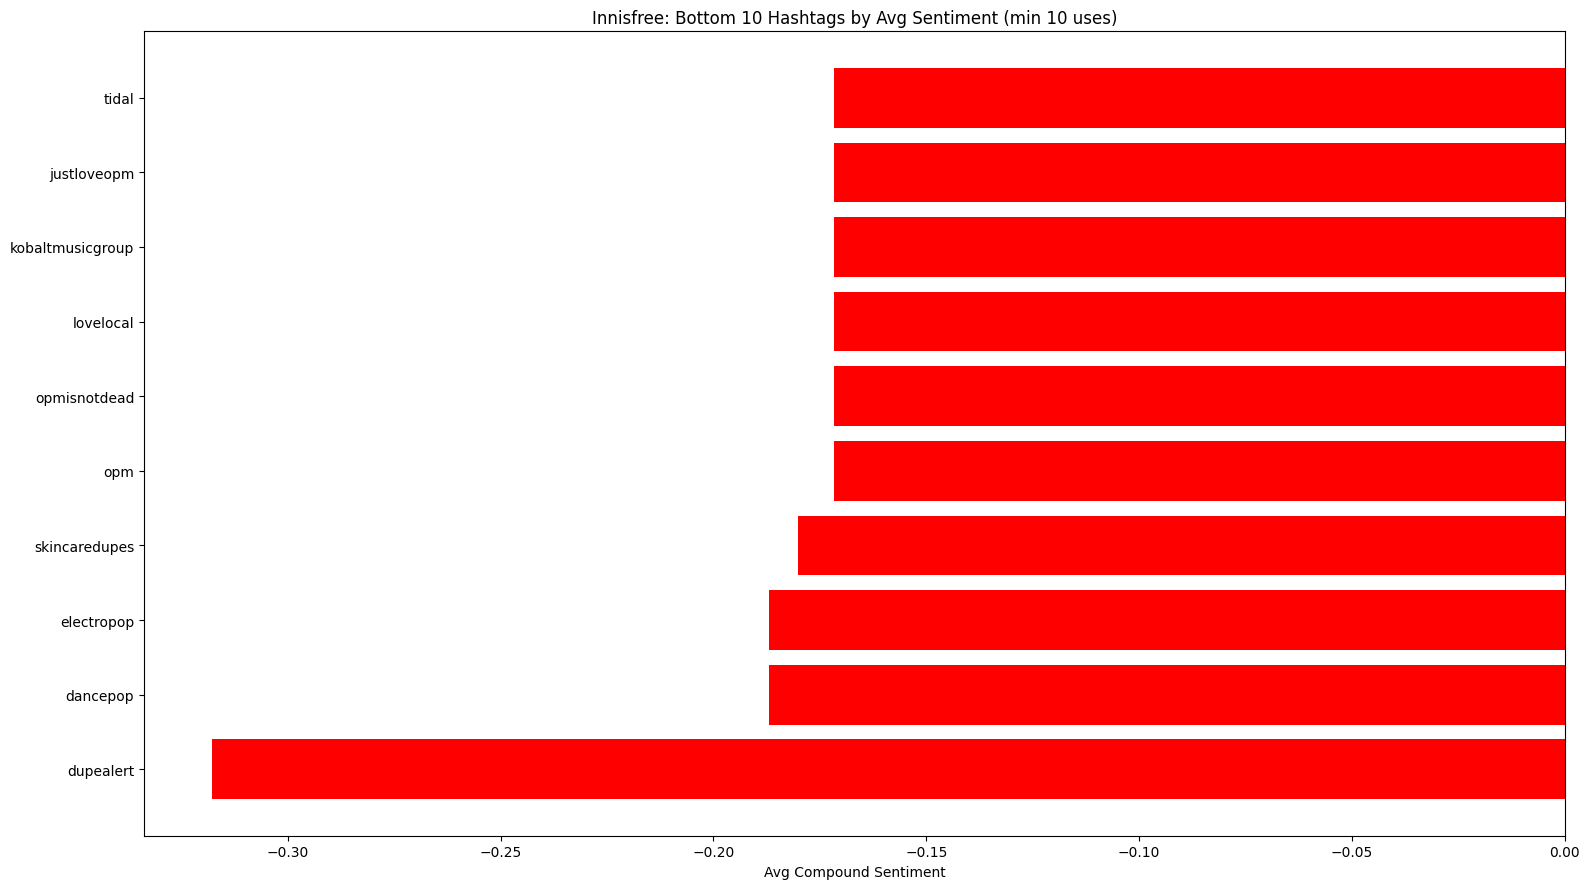

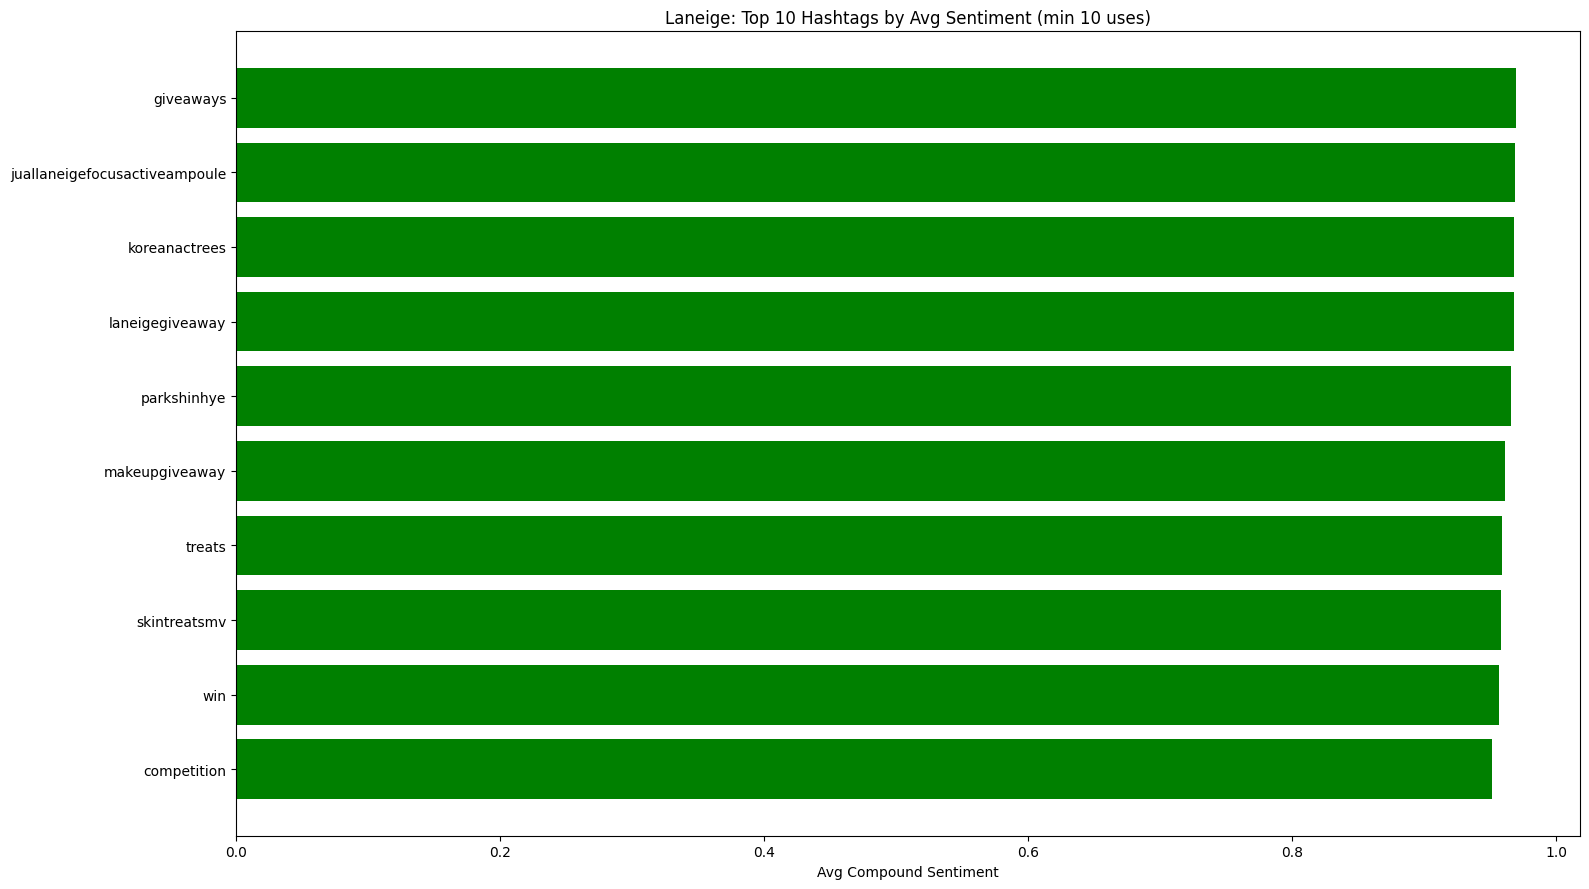

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Laneige: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Sulwhasoo: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

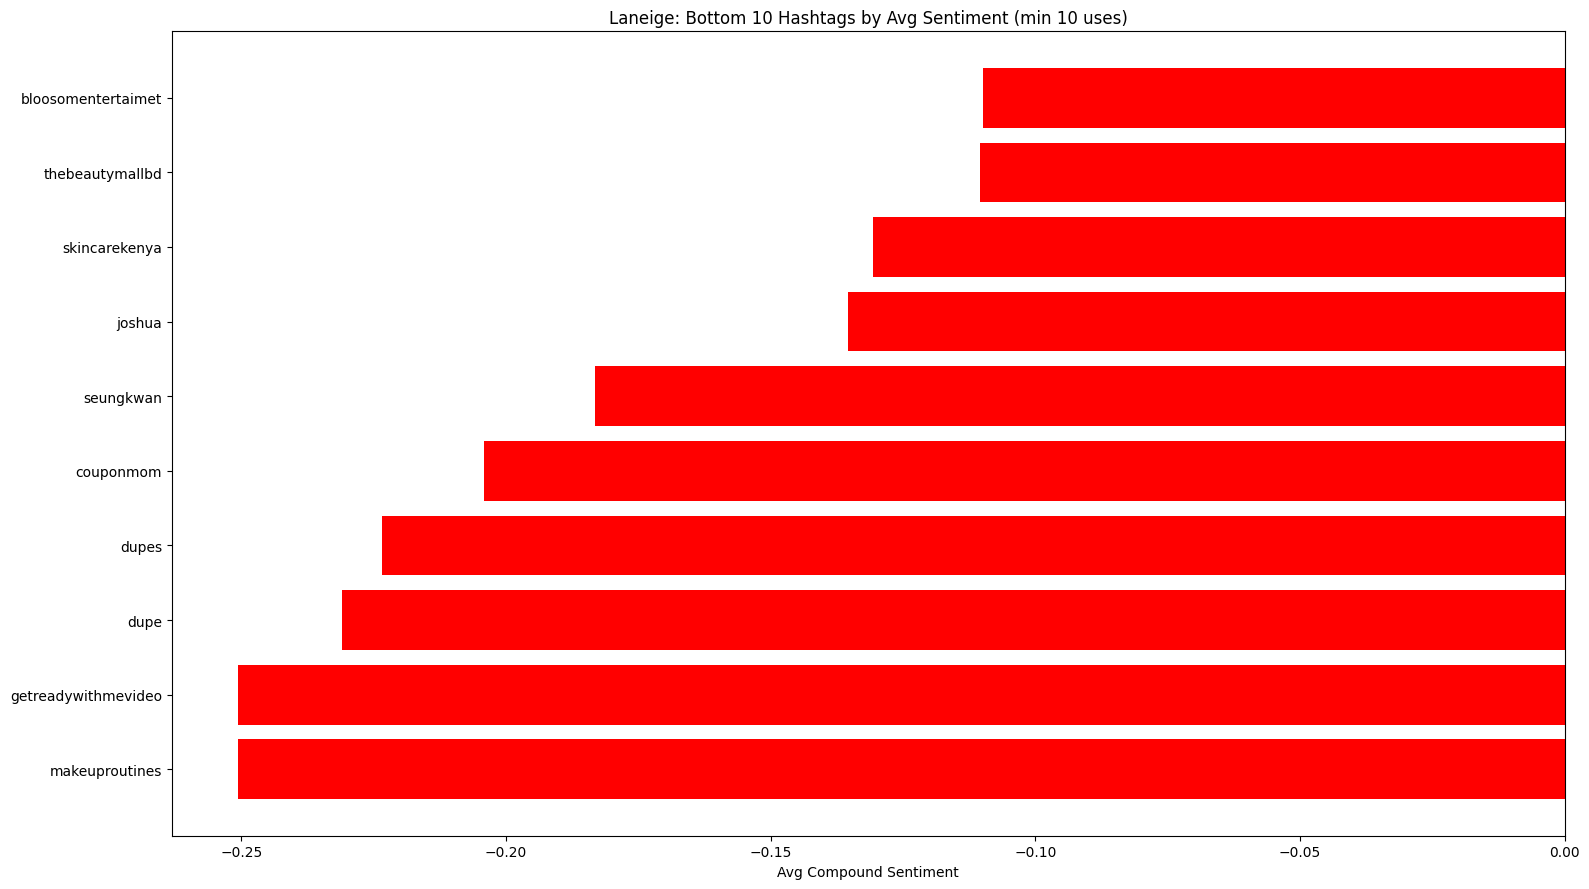

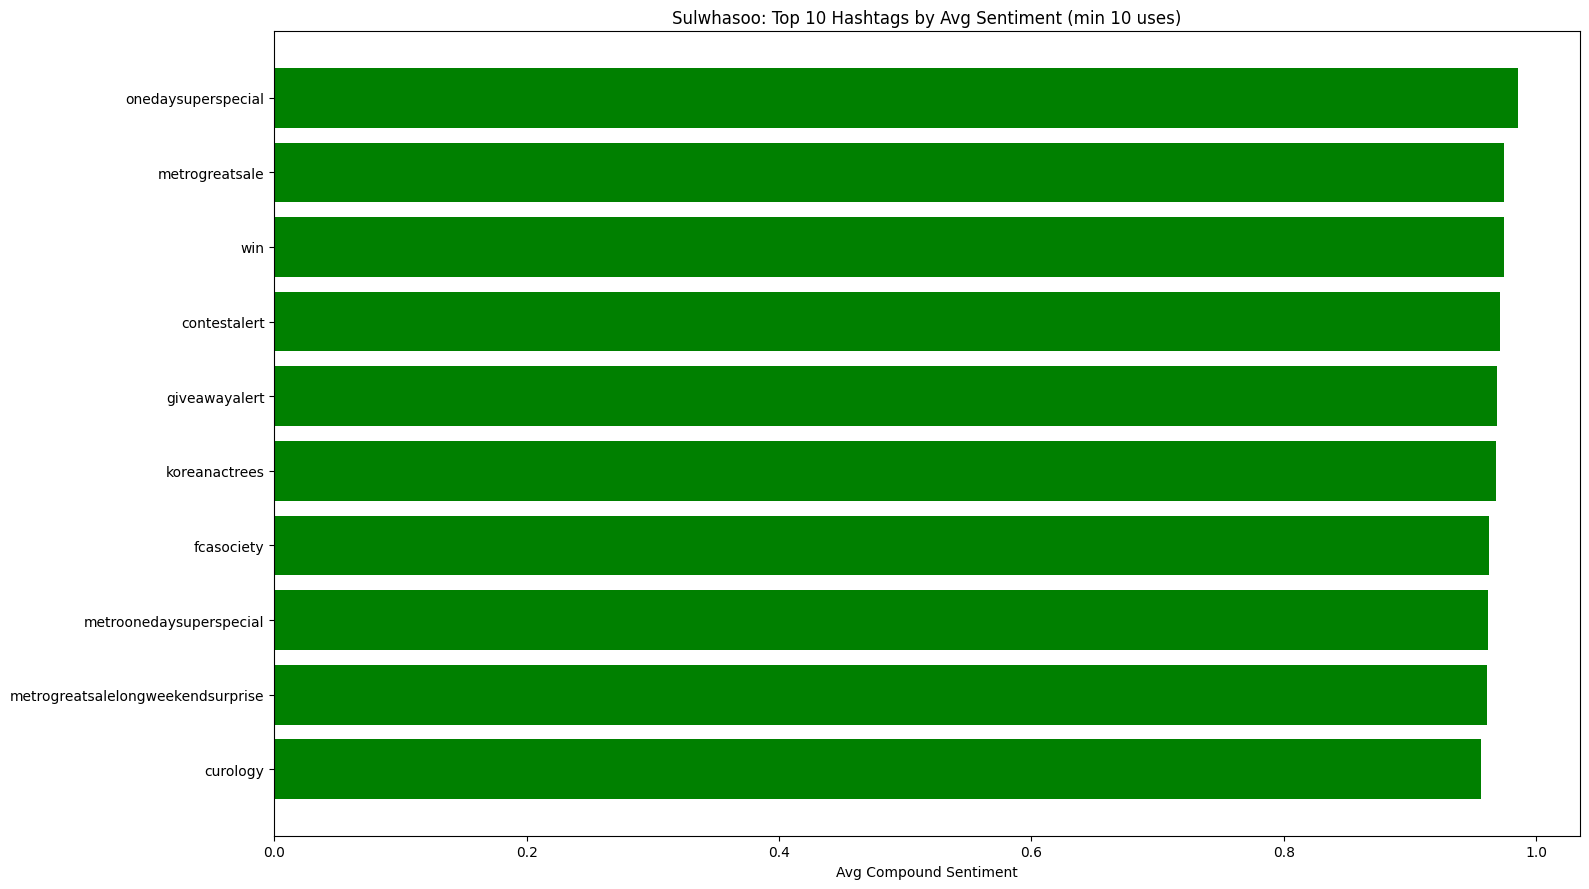

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Sulwhasoo: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Tarte: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

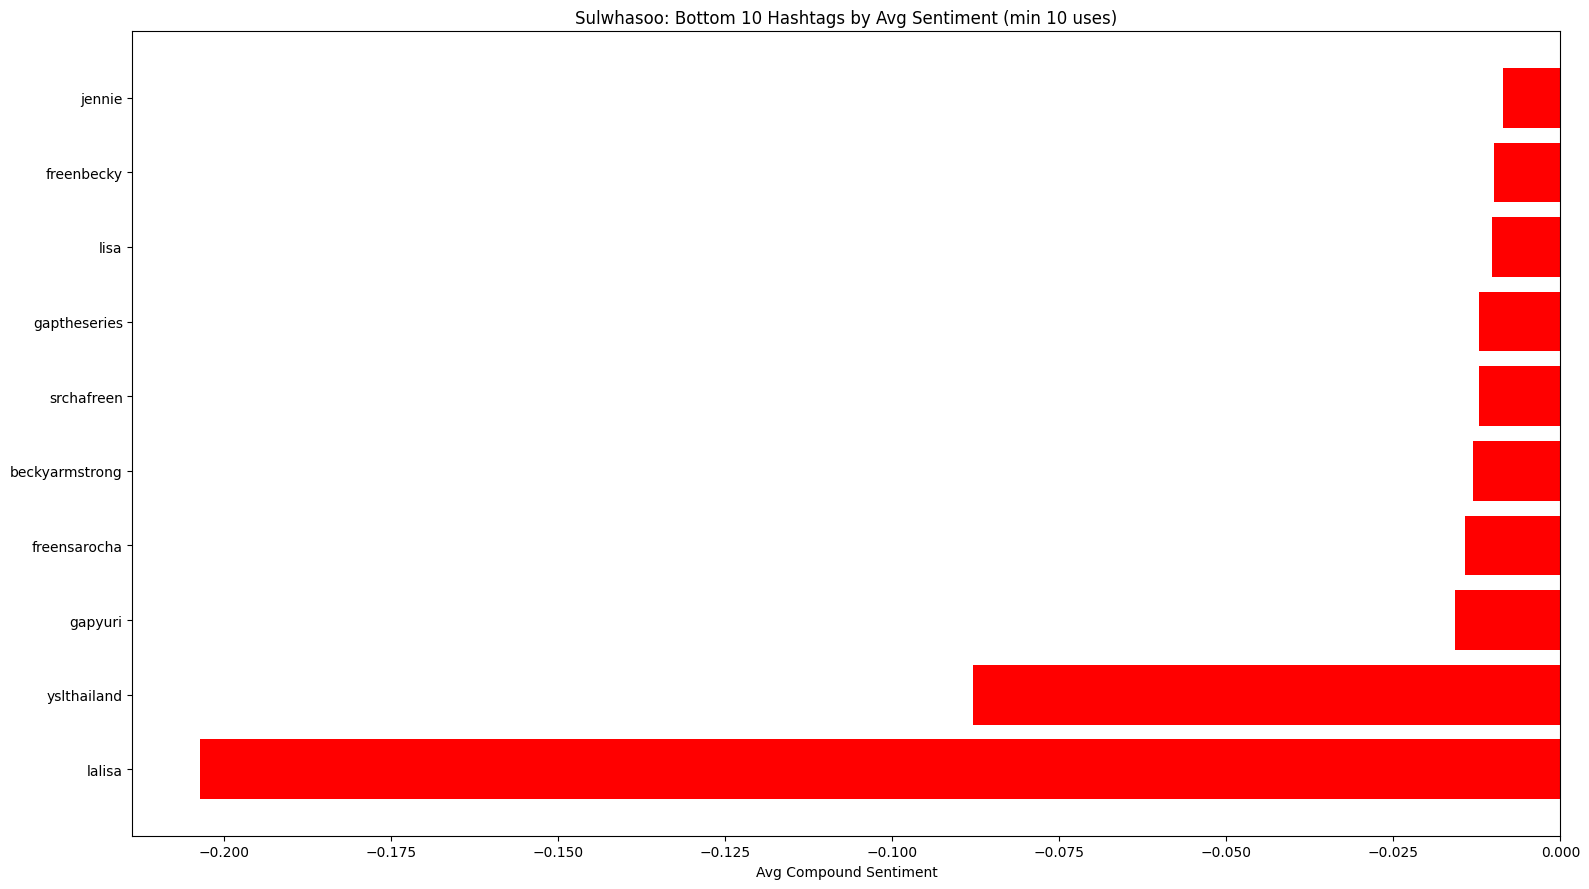

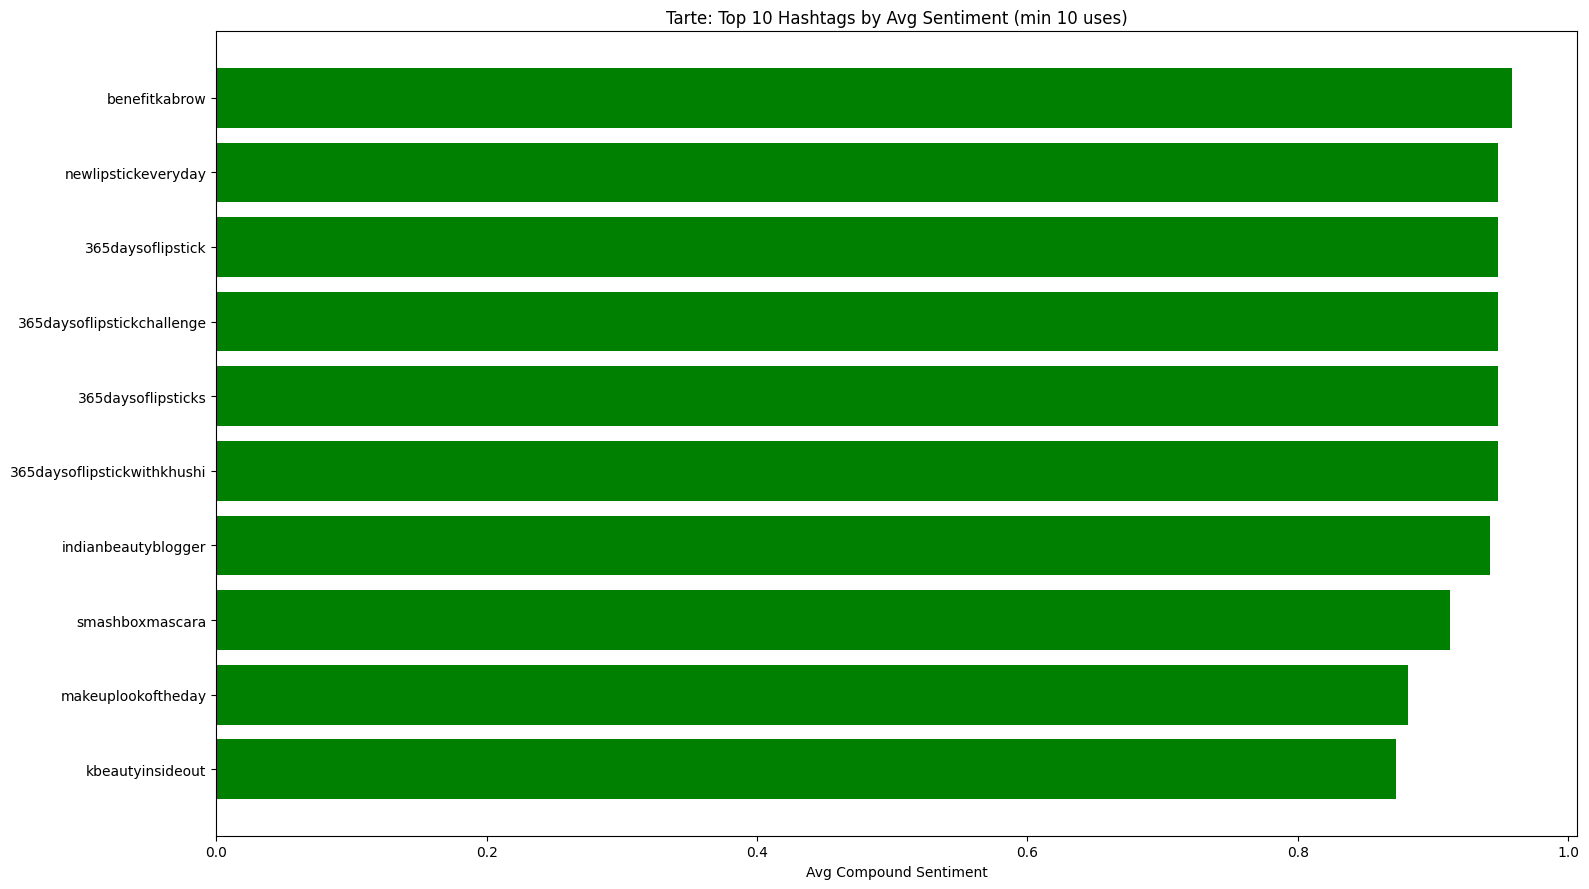

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'Tarte: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'e.l.f: Top 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

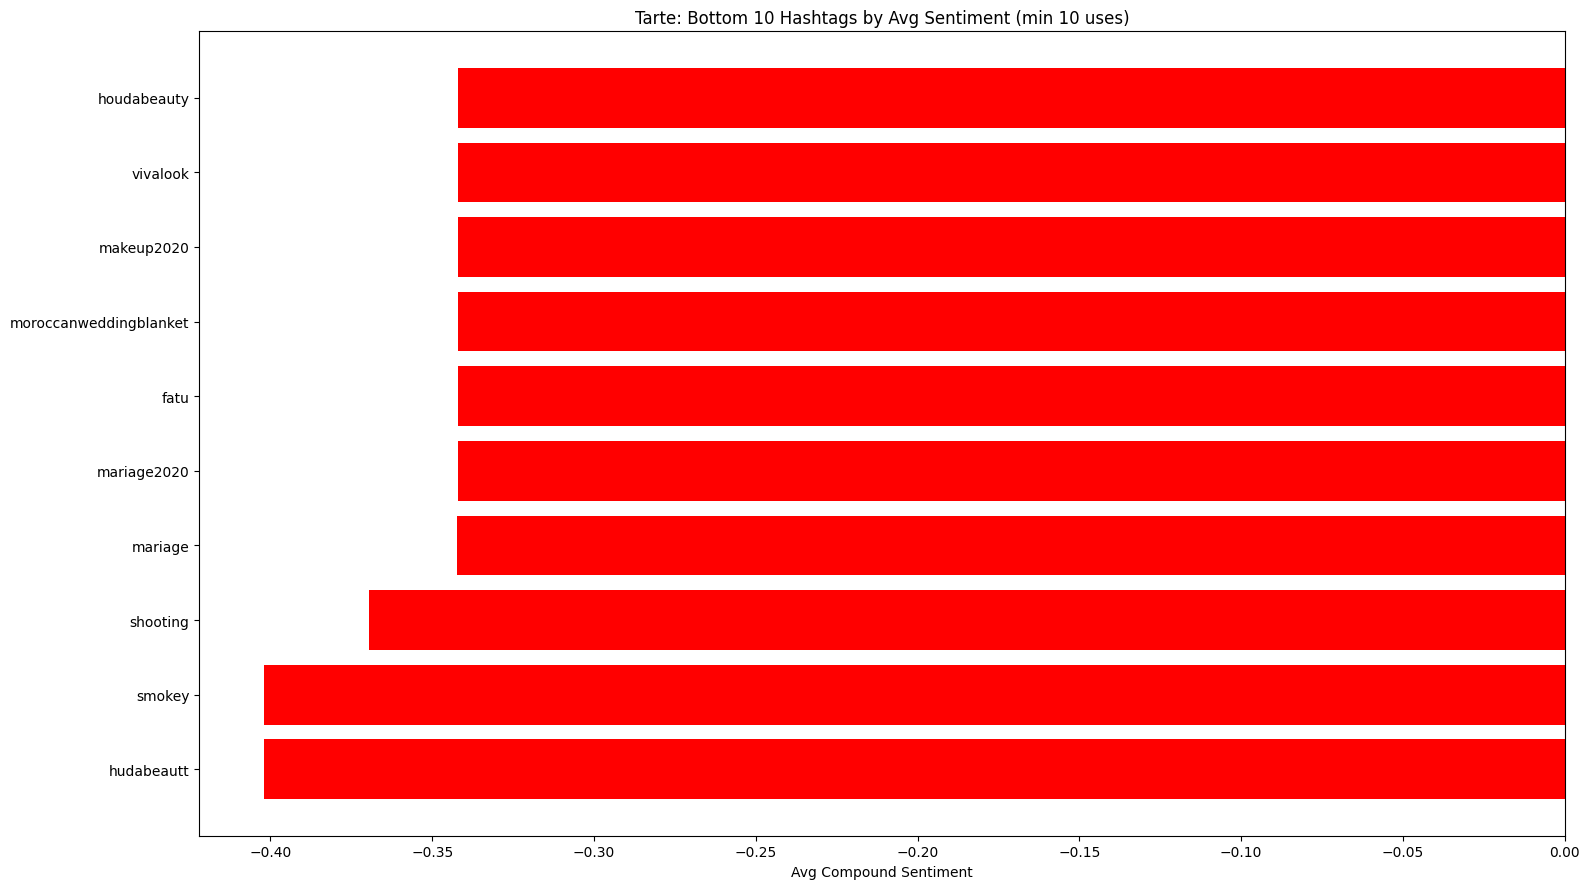

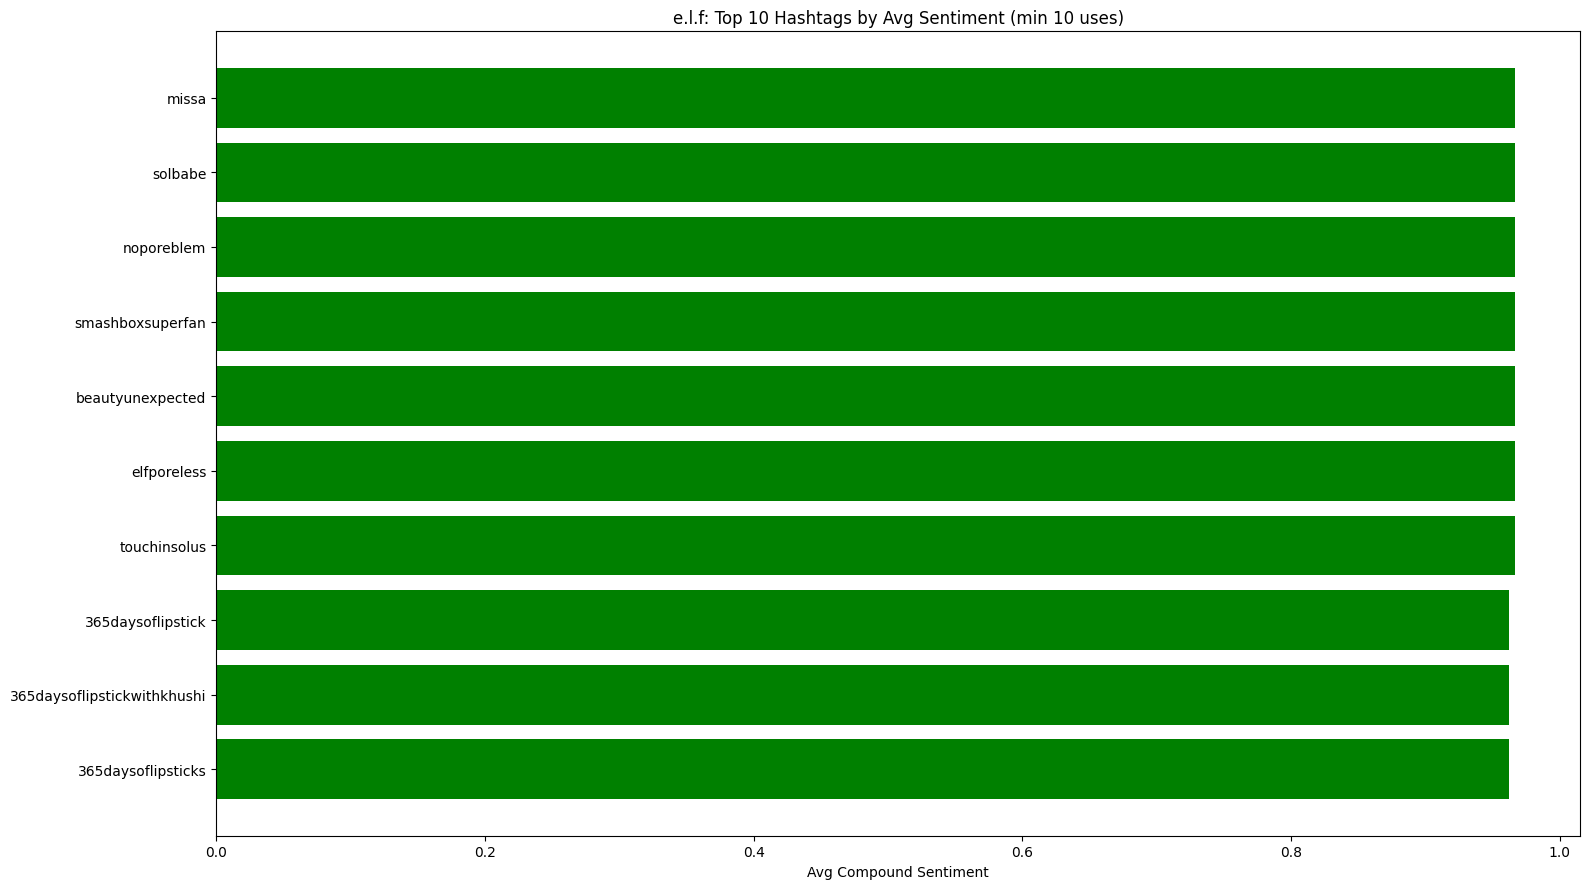

<Figure size 1600x900 with 0 Axes>

<BarContainer object of 10 artists>

Text(0.5, 1.0, 'e.l.f: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)')

Text(0.5, 0, 'Avg Compound Sentiment')

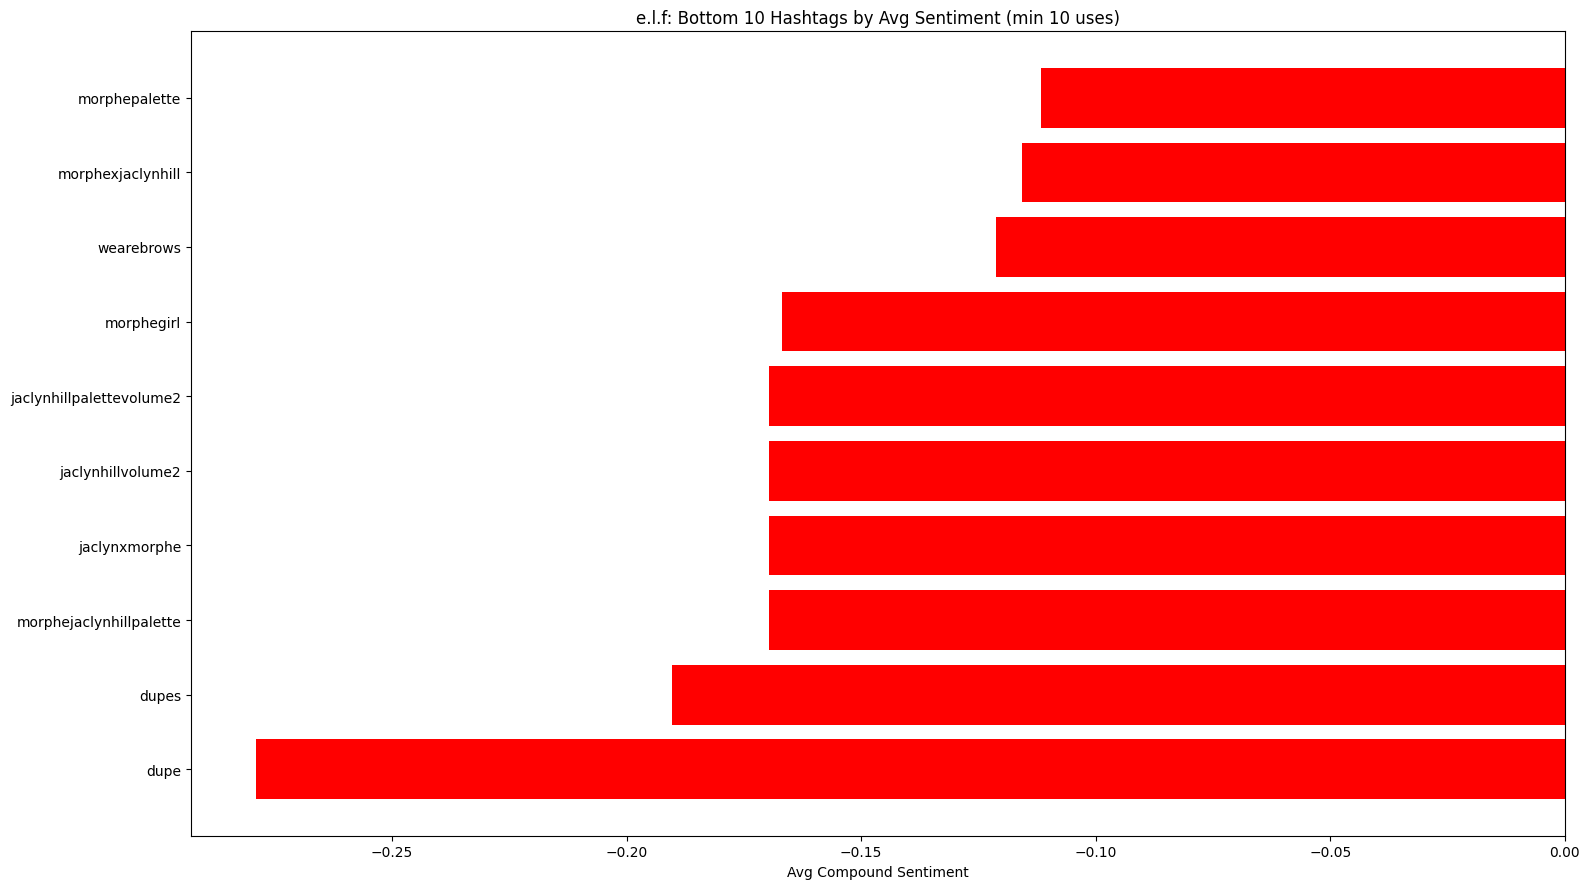

In [58]:
# Clean hashtags
hashtag_sentiment["hashtags"] = hashtag_sentiment["hashtags"].astype(str)
hashtag_sentiment = hashtag_sentiment[
    hashtag_sentiment["hashtags"].apply(lambda x: all(char in string.printable for char in x))
]

# Define list of brands
brands = hashtag_sentiment["brand"].dropna().unique()

# Top/bottom sentiment charts (from hashtag_sentiment)
for brand in brands:
    filtered = hashtag_sentiment[hashtag_sentiment["brand"] == brand]
    filtered = filtered[filtered["count"] >= 10].sort_values("avg_sentiment", ascending=False)

    if len(filtered) < 10:
        continue

    top10 = filtered.head(10)
    bottom10 = filtered.tail(10)

    # Top 10 Hashtags
    plt.figure(figsize=(16, 9))
    plt.barh(top10["hashtags"], top10["avg_sentiment"], color="green")
    plt.title(f"{brand}: Top 10 Hashtags by Avg Sentiment (min 10 uses)")
    plt.xlabel("Avg Compound Sentiment")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    # Bottom 10 Hashtags
    plt.figure(figsize=(16, 9))
    plt.barh(bottom10["hashtags"], bottom10["avg_sentiment"], color="red")
    plt.title(f"{brand}: Bottom 10 Hashtags by Avg Sentiment (min 10 uses)")
    plt.xlabel("Avg Compound Sentiment")
    plt.gca().invert_yaxis()
    plt.tight_layout()


<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'COSRX: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

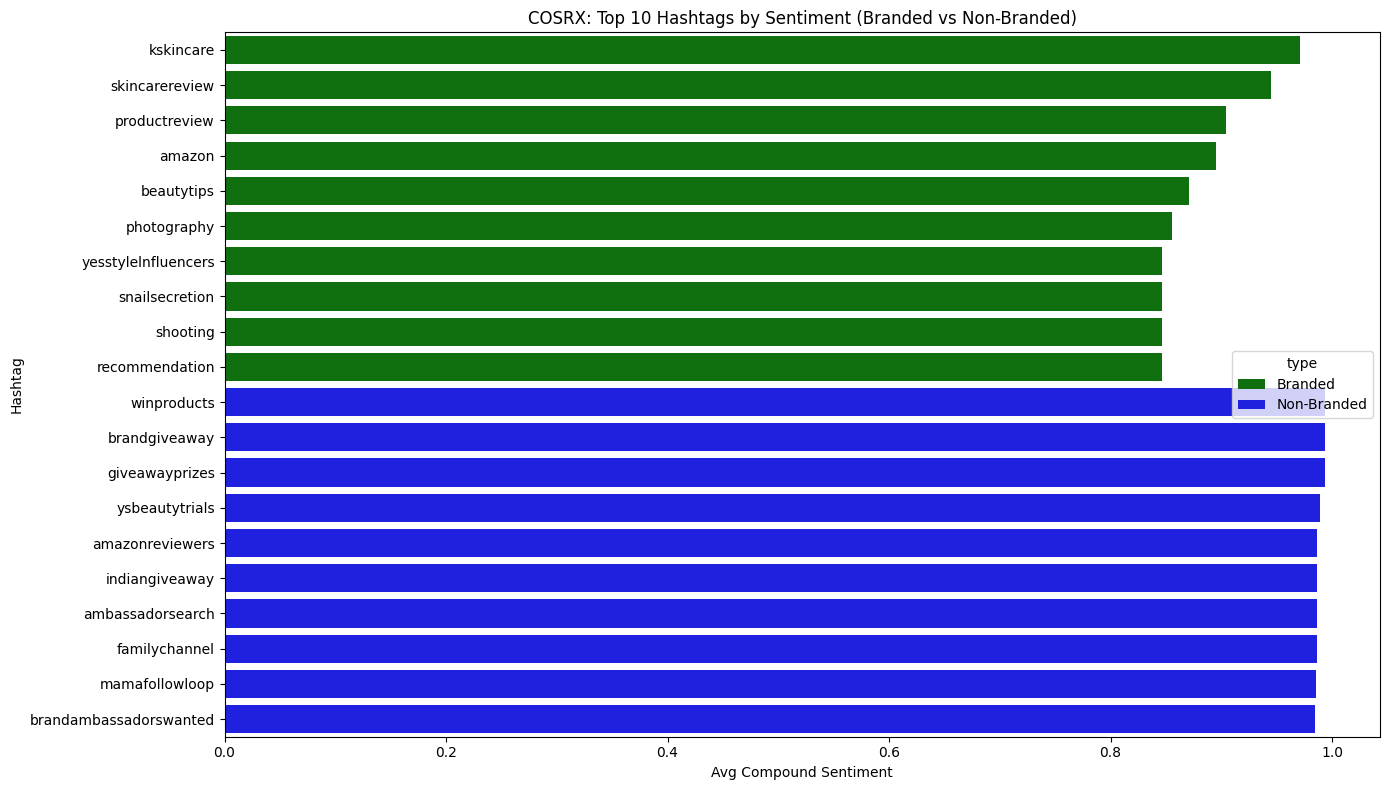

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Estée Lauder: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

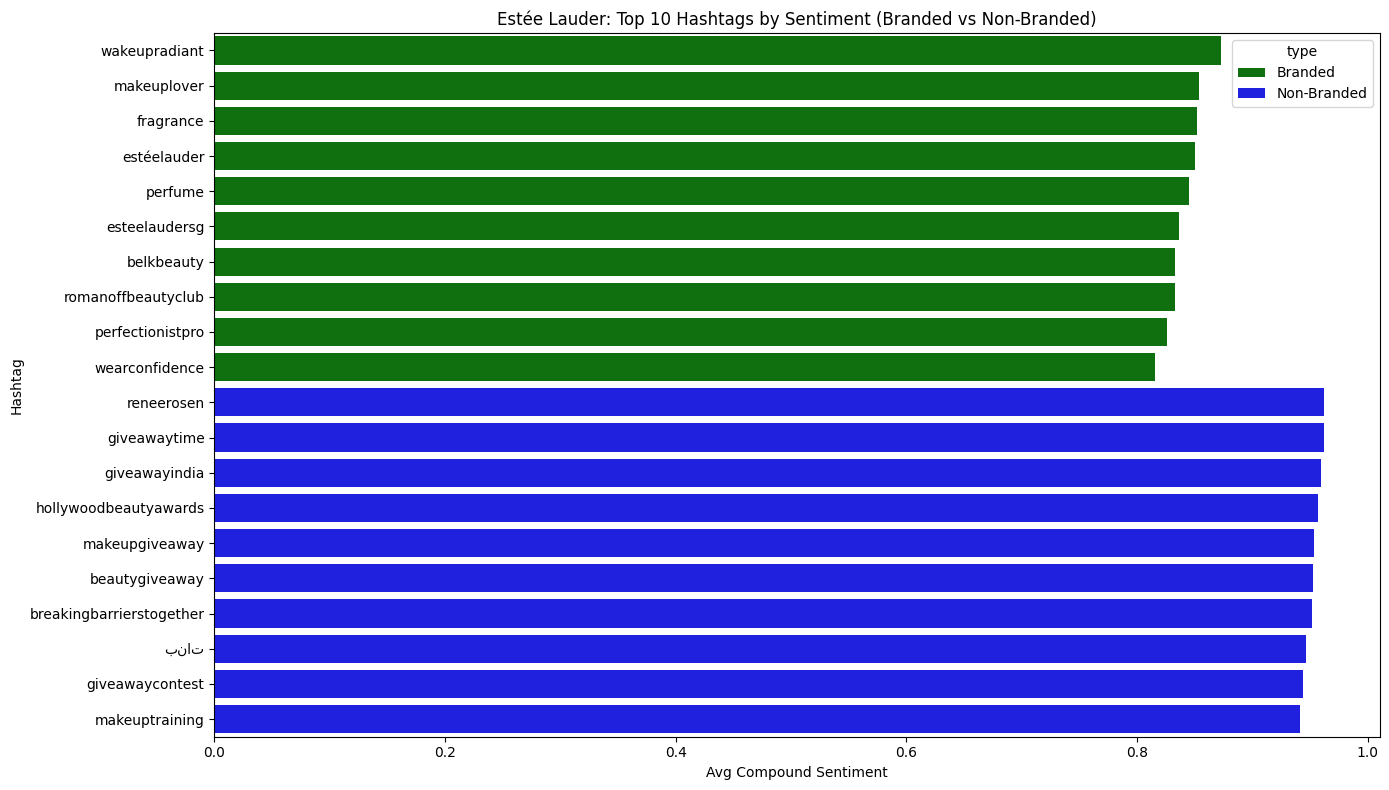

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Etude: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

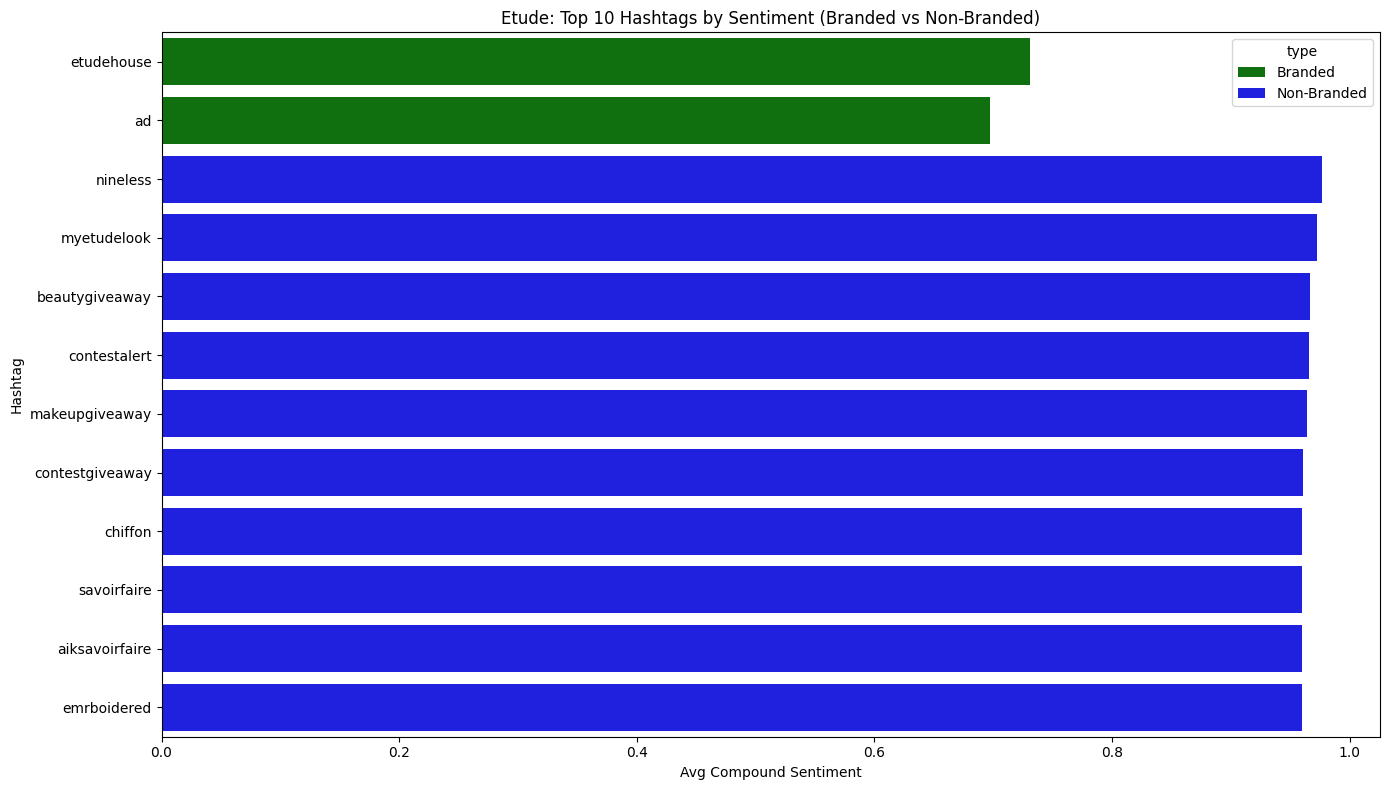

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Fenty Beauty: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

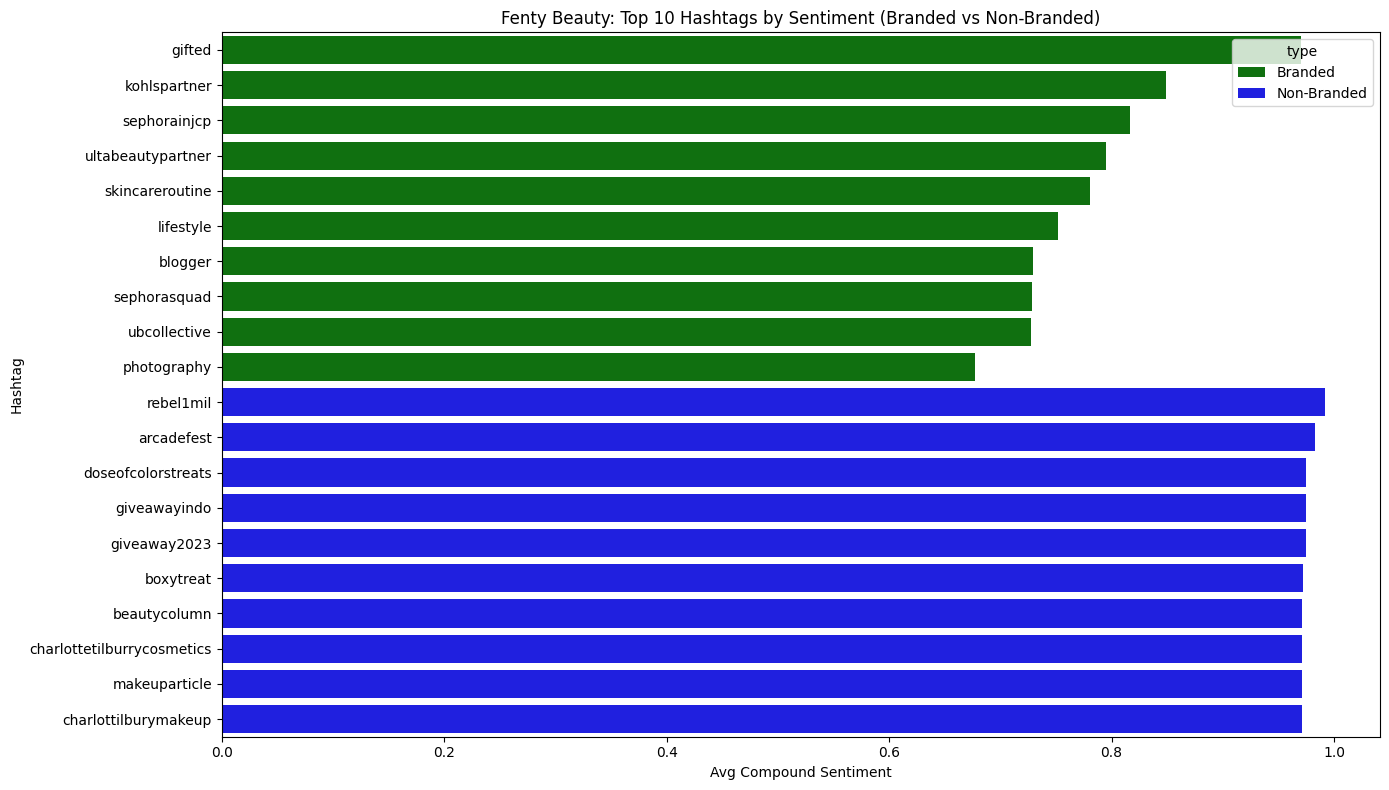

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Glossier: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

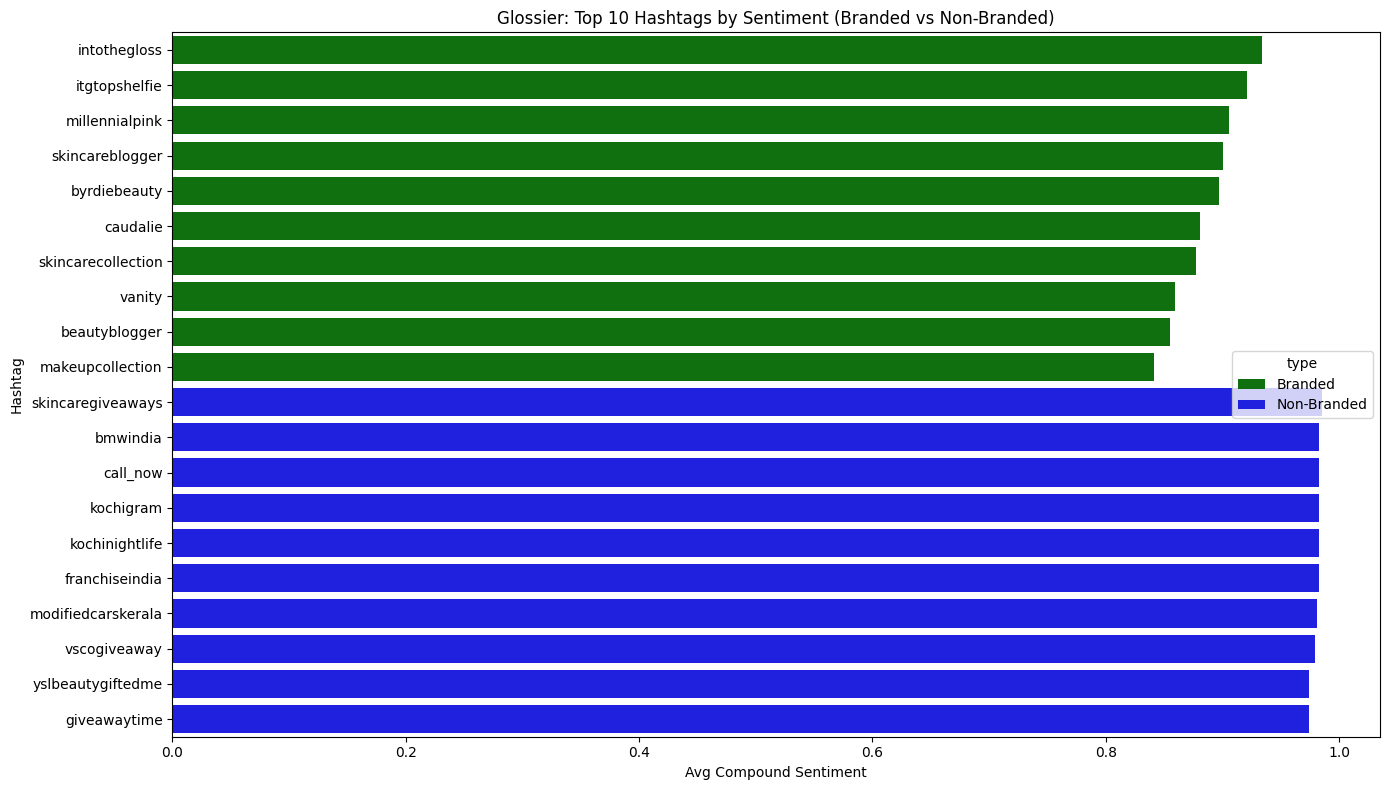

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Innisfree: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/1930904450.py:44: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/1930904450.py:44: UserWarning: Glyph 54665 (\N{HANGUL SYLLABLE HAENG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/1930904450.py:44: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/1930904450.py:44: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/1930904450.py:49: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath, dpi=300, bbox_inches="tight")
/var/folders/j0/hl_vh

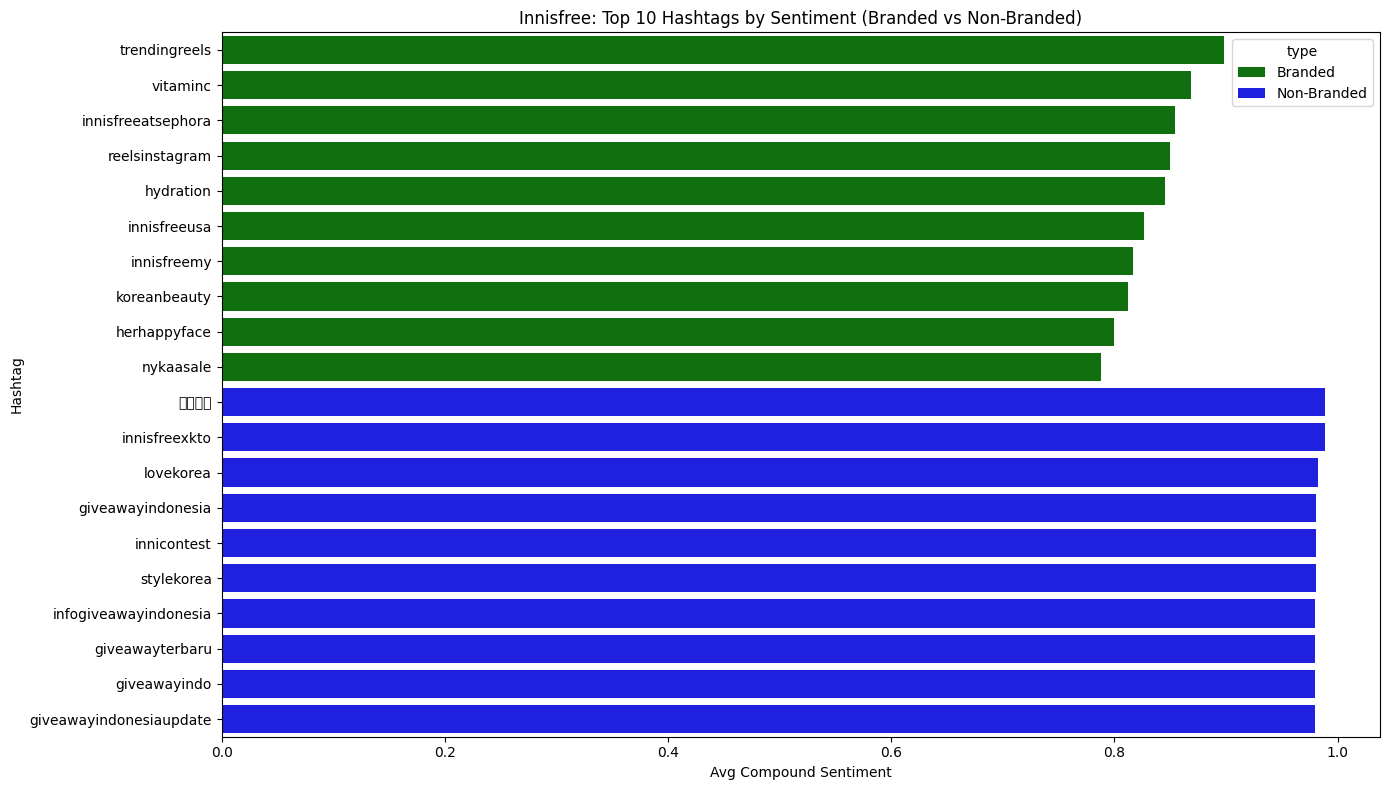

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Laneige: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

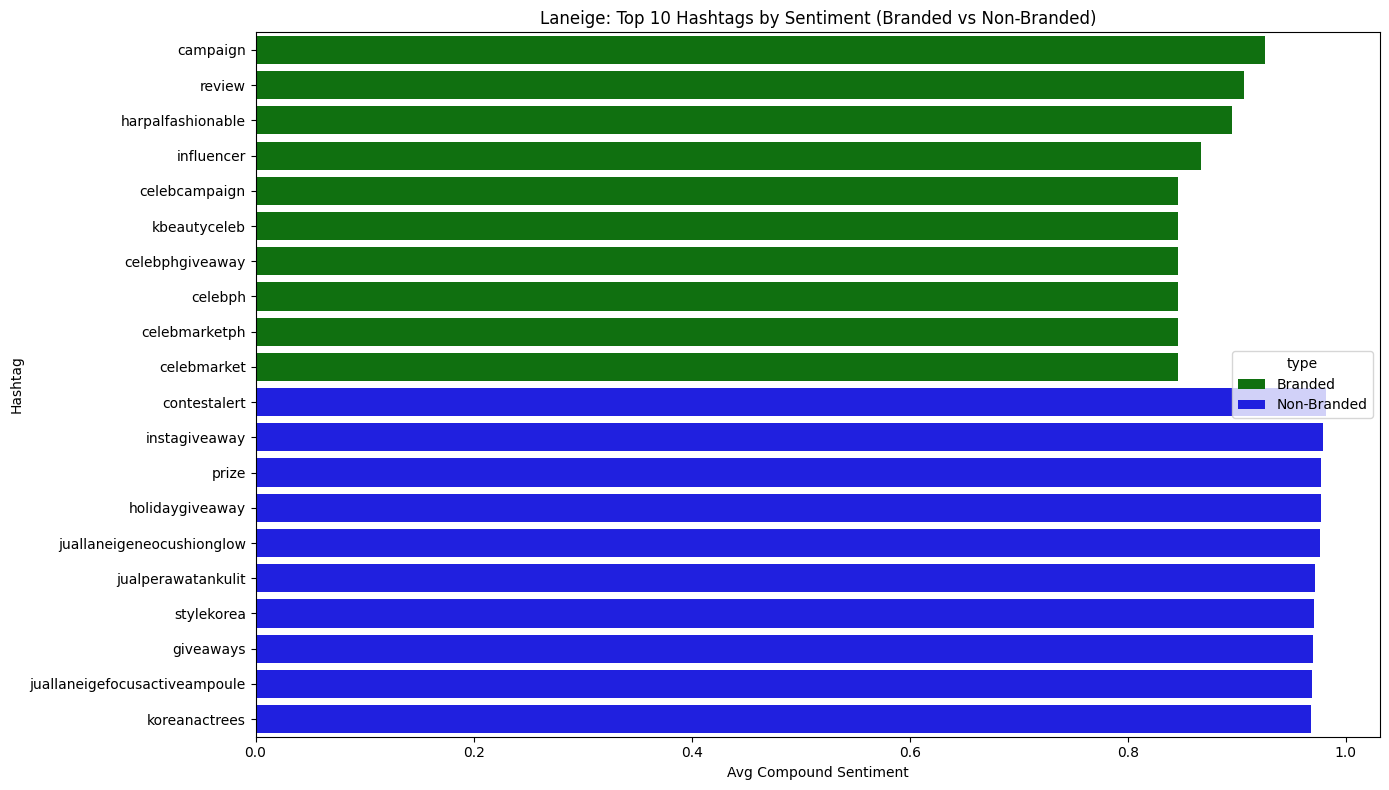

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Sulwhasoo: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

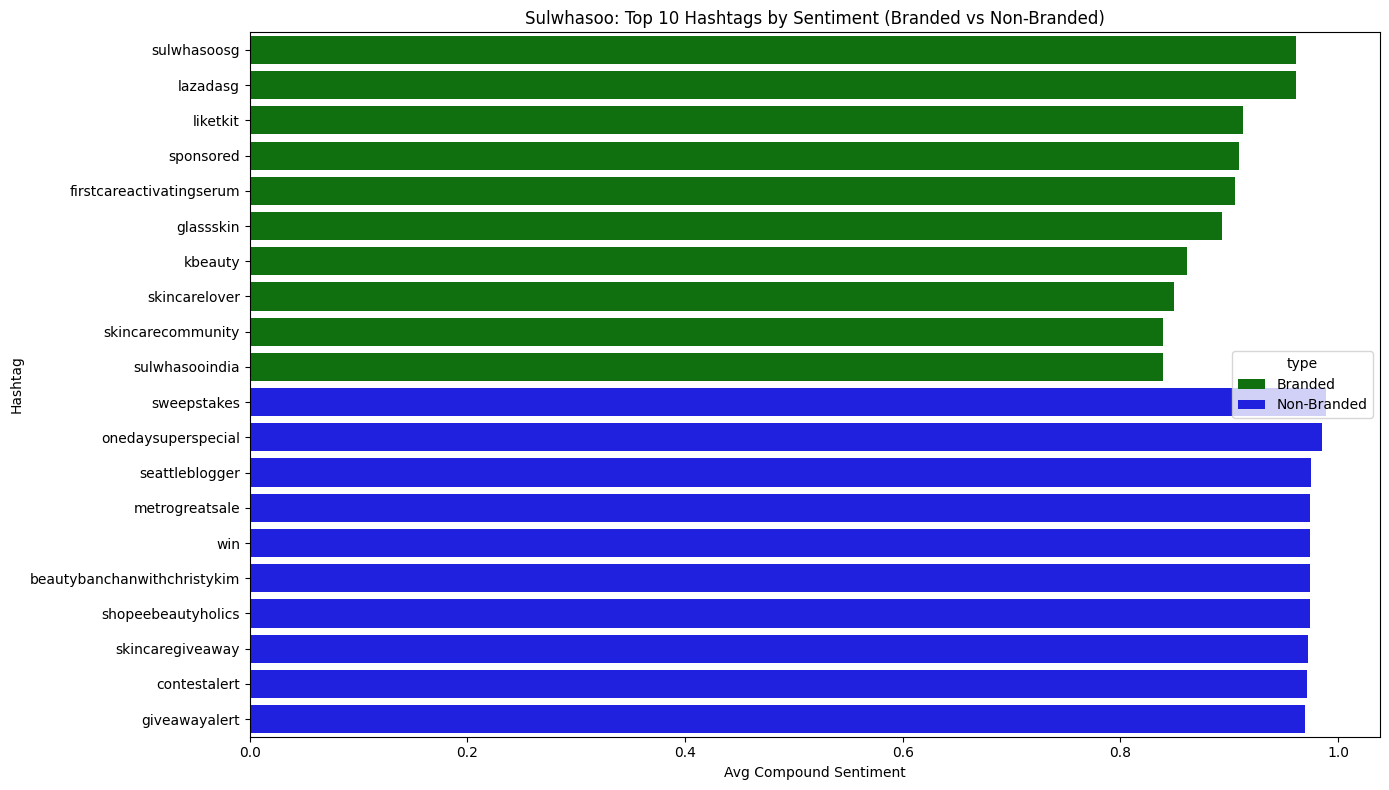

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Tarte: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

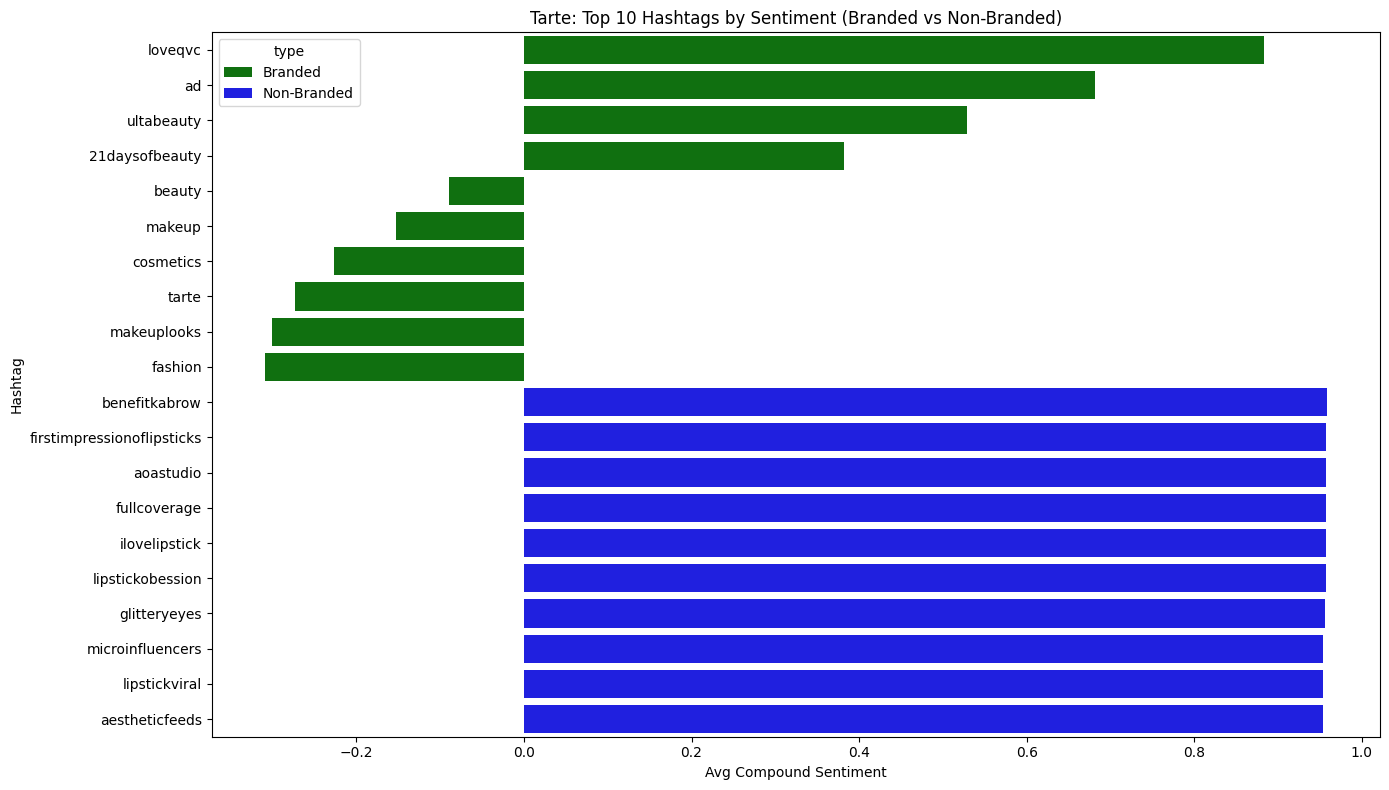

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'e.l.f: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

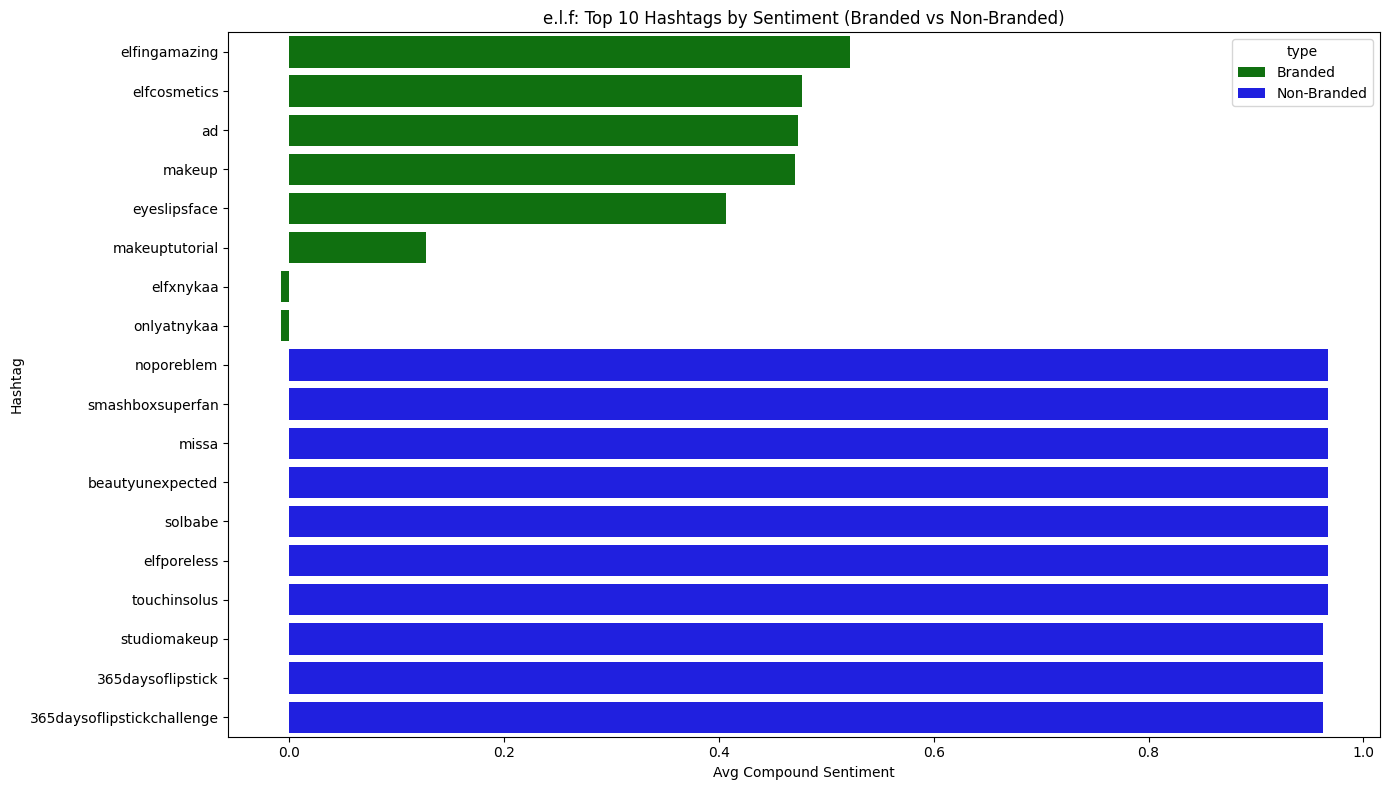

In [61]:
for brand in brands:
    brand_df = hashtag_df[hashtag_df["brand"] == brand]

    if brand_df.empty:
        continue

    # Branded content
    branded = brand_df[brand_df["is_branded_content"] == True]
    branded_grouped = (
        branded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
        .sort_values("avg_sentiment", ascending=False)
        .head(10)
    )
    branded_grouped["type"] = "Branded"

    # Non-branded content
    nonbranded = brand_df[brand_df["is_branded_content"] == False]
    nonbranded_grouped = (
        nonbranded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
        .sort_values("avg_sentiment", ascending=False)
        .head(10)
    )
    nonbranded_grouped["type"] = "Non-Branded"

    # Combine for plotting
    combined = pd.concat([branded_grouped, nonbranded_grouped]).reset_index()

    # Plot and save (horizontal barplot: swap x and y)
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=combined,
        x="avg_sentiment",
        y="hashtags",
        hue="type",
        palette={"Branded": "green", "Non-Branded": "blue"}
    )
    plt.title(f"{brand}: Top 10 Hashtags by Sentiment (Branded vs Non-Branded)")
    plt.xlabel("Avg Compound Sentiment")
    plt.ylabel("Hashtag")
    plt.tight_layout()

    # Safe filename
    filename = f"{brand.lower().replace(' ', '_')}_top10_sentiment.png"
    filepath = os.path.join(output_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()


In [62]:
# Ensure output directory exists
for brand in brands:
    brand_df = hashtag_df[hashtag_df["brand"] == brand]

    if brand_df.empty:
        continue

    # ── Branded content ──
    branded = brand_df[brand_df["is_branded_content"] == True]
    branded_grouped = (
        branded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
    )

    # ── Non-branded content ──
    nonbranded = brand_df[brand_df["is_branded_content"] == False]
    nonbranded_grouped = (
        nonbranded.groupby("hashtags")
        .agg(avg_sentiment=("compound", "mean"), count=("compound", "count"))
        .query("count >= 5")
    )

    # Skip if not enough data
    if branded_grouped.empty or nonbranded_grouped.empty:
        continue

    # ── Bottom 10 sentiment hashtags ──
    branded_bottom = branded_grouped.sort_values("avg_sentiment", ascending=True).head(10)
    branded_bottom["type"] = "Branded"

    nonbranded_bottom = nonbranded_grouped.sort_values("avg_sentiment", ascending=True).head(10)
    nonbranded_bottom["type"] = "Non-Branded"

    bottom_combined = pd.concat([branded_bottom, nonbranded_bottom]).reset_index()

    # ── Order: branded first, then non-branded, both sorted ascending ──
    bottom_combined["type"] = pd.Categorical(bottom_combined["type"], categories=["Branded", "Non-Branded"])
    bottom_combined = bottom_combined.sort_values(by=["type", "avg_sentiment"], ascending=[True, True])

    # Plot
    plt.figure(figsize=(14, 8))
    sns.barplot(
        data=bottom_combined,
        y="hashtags",
        x="avg_sentiment",
        hue="type",
        palette={"Branded": "darkred", "Non-Branded": "gray"}
    )
    plt.title(f"{brand}: Bottom 10 Hashtags by Sentiment (Branded on Top)")
    plt.xlabel("Avg Compound Sentiment")
    plt.ylabel("Hashtag")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Save plot
    filename = f"{brand.lower().replace(' ', '_').replace('.', '')}_bottom10_sentiment.png"
    filepath = os.path.join(output_path, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.close()

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'COSRX: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Estée Lauder: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Etude: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 23448 (\N{CJK UNIFIED IDEOGRAPH-5B98}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 24196 (\N{CJK UNIFIED IDEOGRAPH-5E84}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:59: UserWarning: Glyph 27491 (\N{CJK UNIFIED IDEOGRAPH-6B63}) missing from font(s) DejaVu Sans.
  plt.savefig(filepath, dpi=300, bbox_inches='tight')
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:59: UserWarning: Glyph 23448 (\N{CJK UNIFIED IDEOGRAPH-5B98}) missing from font(s) DejaVu Sans.
  plt.savefig

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Fenty Beauty: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Glossier: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Innisfree: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Laneige: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Sulwhasoo: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 48660 (\N{HANGUL SYLLABLE BEUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 47001 (\N{HANGUL SYLLABLE RAEG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 54592 (\N{HANGUL SYLLABLE PIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 53356 (\N{HANGUL SYLLABLE KEU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_99600/560744159.py:54: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/j0/hl_vhf4s5yd2k4y2b4txq0_m0000gn/T/ipykernel_

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'Tarte: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')

<Figure size 1400x800 with 0 Axes>

<Axes: xlabel='avg_sentiment', ylabel='hashtags'>

Text(0.5, 1.0, 'e.l.f: Bottom 10 Hashtags by Sentiment (Branded on Top)')

Text(0.5, 0, 'Avg Compound Sentiment')

Text(0, 0.5, 'Hashtag')